# Here analysis is done of the clusters of sequences in SVD space for Charlotte's RNaseH ancestral tree MSA. 
Here analysis is done of the clusters of sequences in SVD space for Charlotte's RNaseH ancestral tree MSA.
Project the 409 sequences into SV space along with consensus, AncX's, and AncX_consensus. Sequence file for SVD is called *RNHtreealignment_gapStrip.txt*.  K-means cluster the sequences, and then plot the residues, colored by cluster and scaled by number of sequences in the cluster.

Also, display with various descendant sequence groups from the different ancestral nodes.  The sequence file for these is *RNH_align_to_tree.txt*.

And calculate "not" groups--sequences within the tree that are from one node but not the one below.  For example, descendent from ancestor A but not from ancestor B (A_not_B).

5/1/22

## 1.  Import and vectorize the MSA

In [52]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import os
import imageio

In [53]:
def alignment_sequences(in_fasta):
    seqs = []
    names = []
    testSeq= ''
    
    with open(in_fasta, 'r') as n:
        for line in n:
            if line[0] == '>':
                names.append(line.rstrip())
                if len(testSeq) > 0:
                    seqs.append(testSeq)
                testSeq = ''
            else:
                testSeq += line.rstrip()
        seqs.append(testSeq)
        
    return seqs, names

In [54]:
def ohe_msa(seqs, res='ACDEFGHIKLMNPQRSTVWY'):
    lett2index = {aa:i for i,aa in enumerate(res)}
    
    ohe_algn = []
    
    for seq in seqs:
        seq_vector = []
        for pos in seq:
            pos_vector = np.zeros(len(res))
            if pos in res:
                res_index = lett2index[pos]
                pos_vector[res_index] = 1
            seq_vector.append(pos_vector)
        ohe_algn.append(np.array(seq_vector).flatten())
        
    return(np.array(ohe_algn))

In [55]:
make_movies = False # Set to true to make movies below
msa_file = 'RNHtreealignment_gapStrip.txt'
RNtree, RNtree_names = alignment_sequences(msa_file)
F = ohe_msa(RNtree)
print(f'The shape of the vectorized squence matrix is {np.shape(F)}.')
print(f'Rank of the the vectorized squences matrix F {np.linalg.matrix_rank(F)}.\n')

The shape of the vectorized squence matrix is (409, 3020).
Rank of the the vectorized squences matrix F 409.



## 2. Extract the consensus sequence from the MSA and vectorize

In [56]:
rows = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-', 'cons']

cols = []
i = 0
while i < len(RNtree[0]):
    cols.append(i+1)
    i += 1

zeros = np.zeros((len(rows), len(cols)))
composition_df = pd.DataFrame(zeros, index = rows, columns = cols)

for seq in RNtree:
    position = 1
    while position <= len(seq):
        char = seq[position - 1]
        composition_df[position][char] = composition_df[position][char] + 1
        position += 1

In [7]:
composition_df.head()

1     2     3     4    5      6     7      8     9      10   ...   142  \
A  13.0  10.0  13.0  11.0  2.0    6.0  45.0    4.0   6.0    0.0  ...  85.0   
C   0.0   0.0   0.0   2.0  0.0    1.0   0.0    0.0  11.0    0.0  ...   1.0   
D  12.0   9.0  29.0  23.0  1.0   27.0   0.0    0.0   0.0  405.0  ...  61.0   
E  22.0  17.0  17.0  49.0  0.0  157.0   0.0    0.0   0.0    0.0  ...  90.0   
F   1.0   1.0   1.0   0.0  0.0   18.0   0.0  141.0   2.0    0.0  ...   0.0   

    143   144   145   146   147    148   149   150   151  
A  32.0  42.0  27.0  28.0  30.0   16.0  34.0  13.0  23.0  
C   1.0   0.0   2.0   1.0   1.0    1.0   1.0   1.0   0.0  
D  11.0   4.0  15.0   3.0  23.0  119.0   5.0   3.0   4.0  
E  71.0   5.0   8.0  16.0  67.0    7.0  24.0   3.0   9.0  
F   2.0  58.0   0.0   6.0   0.0    2.0   3.0   1.0  27.0  

[5 rows x 151 columns]

In [57]:
consensus_seq = ''
    
position = 1
while position <= len(RNtree[0]):
    consensus_seq = consensus_seq + composition_df[position][0:20].idxmax()
    position += 1
    
print(f'The consensus sequence is {consensus_seq}.')

The consensus sequence is MMKQVEIYTDGACSGNPGPGGWGAVLRYGGHEKELSGGEALTTNNRMELMAAIEALEALKRPCEVTLYTDSQYVRNGITEWIHGWKKNGWKTADKKPVKNVDLWQRLDAAVARHQVTWHWVKGHAGHPENERADELARAAAEEPKLEDTGY.


In [58]:
consensus_seq_vec = ohe_msa(consensus_seq)
consensus_seq_vec.flatten()

array([0., 0., 0., ..., 0., 0., 1.])

## 3. Perform SVD on uncentered sequence matrix F.

In [59]:
U_F, S_F, VT_F = np.linalg.svd(F)
V_F = VT_F.transpose()

if np.sum(V_F[:, 0]) < 0:
    U_F = -U_F
    V_F = -V_F
    VT_F = -VT_F

print(f'The shape of U is {U_F.shape}.')
print(f'The shape of S is {S_F.shape}.')
print(f'The shape of VT is {VT_F.shape}.')

print(f'\nThe first ten singular values of F are:\n {S_F[:10]}')
print(f'\nThe last ten singular of F are:\n {S_F[-10:-1]}')

The shape of U is (409, 409).
The shape of S is (409,).
The shape of VT is (3020, 3020).

The first ten singular values of F are:
 [178.49377678  44.61708857  39.2804211   33.60948036  27.43059501
  24.59040252  23.21394588  21.98205635  20.90207237  19.87564968]

The last ten singular of F are:
 [1.55135106 1.53560062 1.50044021 1.49052379 1.45791433 1.43462949
 1.37072414 1.32665874 1.26300134]


## 7. Generating the sequence principal components of the consensus sequence

The calculation below gives the principal components times the u values for the consensus sequene.  For some reason when the consensus sequence is vectorized, it is not flattened by Matt's ohe_msa function.  That is the reason there is a "flatten" command in the matrix multiplication below (really a sequence row times a matrix).

In [60]:
consensus_usig_i = np.matmul(consensus_seq_vec.flatten(), V_F)

In [61]:
consensus_usig_i[:10]

array([10.7933695 ,  0.22601117, -1.25709026,  0.68790638, -0.60545055,
        0.9840947 , -0.13175988,  0.55382916, -0.59487502, -0.43130349])

## 8. Import alignned ancestral and tax-derived consensus sequences and project into SVD space.

In [62]:
msa_file = 'RNH_align_to_tree.txt'
anc_con_seqs, tree_names = alignment_sequences(msa_file)
F_anc_con = ohe_msa(anc_con_seqs)
print(f'The shape of the vectorized squence matrix F_anc_con is {np.shape(F_anc_con)}.')
print(f'Rank of the the vectorized squences matrix F_anc_con is {np.linalg.matrix_rank(F_anc_con)}.\n')

The shape of the vectorized squence matrix F_anc_con is (12, 3020).
Rank of the the vectorized squences matrix F_anc_con is 12.



In [63]:
anc_cons_F_dict = {}
anc_cons_usig_i_dict = {}

i = 0
for name in tree_names:
    anc_cons_F_dict[name] = F_anc_con[i]
    anc_cons_usig_i_dict[name] = np.matmul(F_anc_con[i], VT_F.transpose())
    i += 1

This generates a 3-d plot and movie of the sequences in the first three SV dimensions.  Not sure why, but you can't number the fig, e.g., fig8 = fig.add ... .

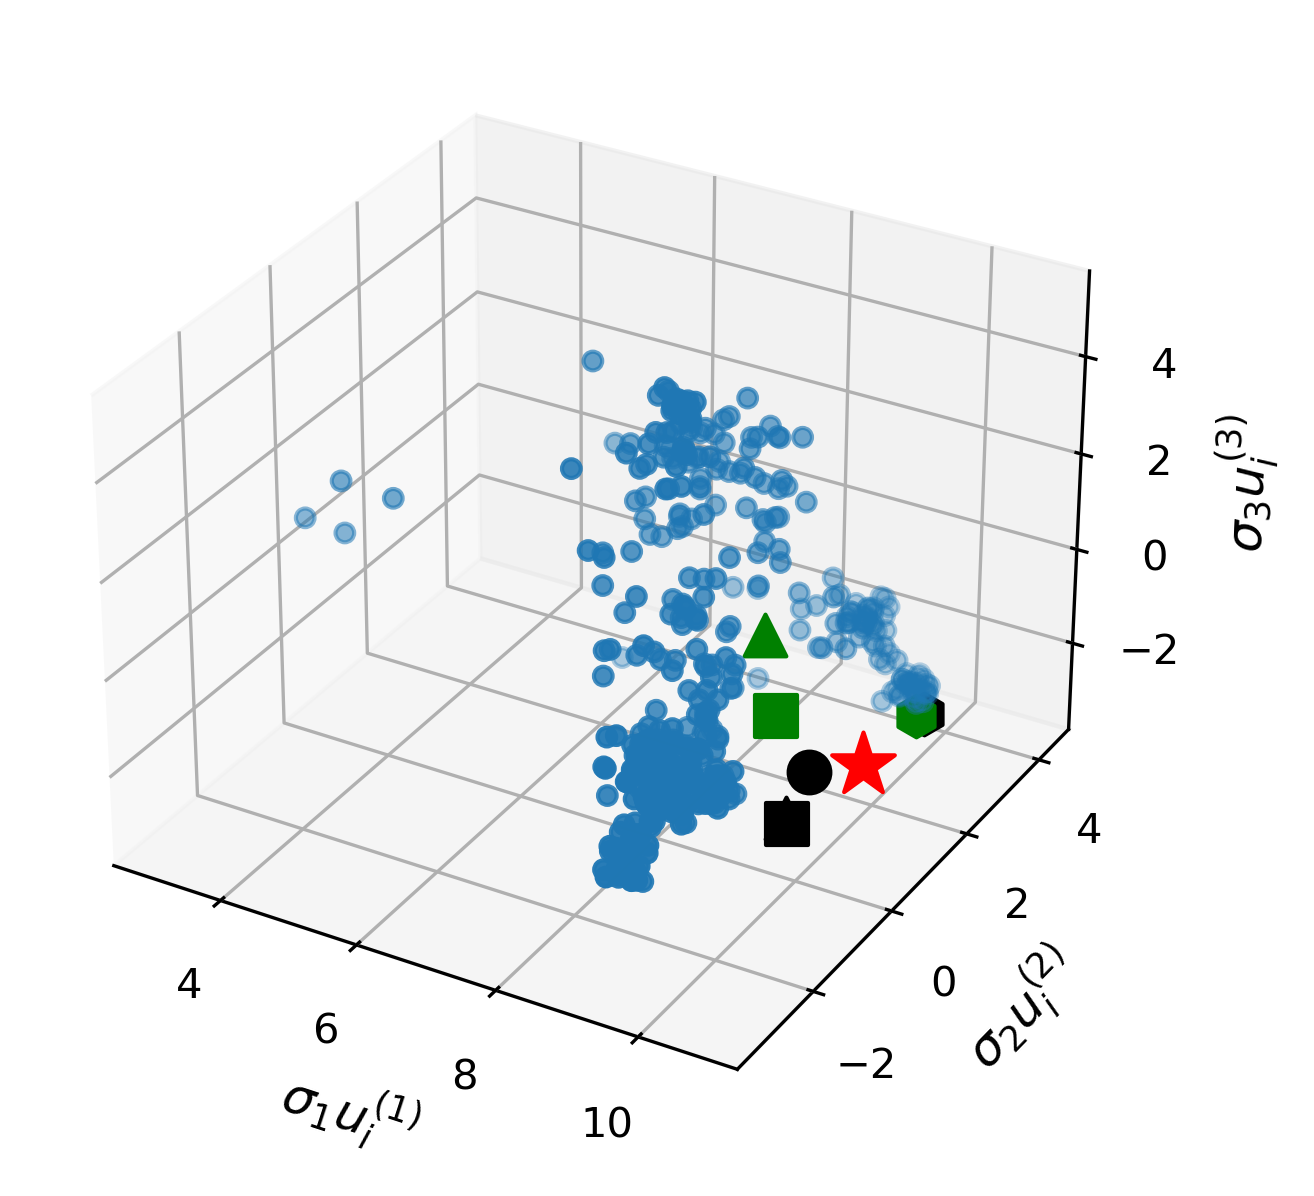

In [13]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(S_F[0]*U_F[:,0], S_F[1]*U_F[:,1], S_F[2]*U_F[:,2], marker = 'o')

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='g', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='g', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='g', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='k', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='k', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='k', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='k', s=100, marker='h')

ax.scatter(consensus_usig_i[0], consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()

make_movies = False
if make_movies:
    imagedata = []
    for ii in range(0,360,1):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)
        data = imageio.imread('movie{}.png'.format(ii))
        imagedata.append(data)
    imageio.mimwrite('rnaseH_tree_seq.mp4', imagedata, format= '.mp4', fps = 20)




## 9. Plot residues in SV space

Below is a 3-dimensional plot and movie generator:

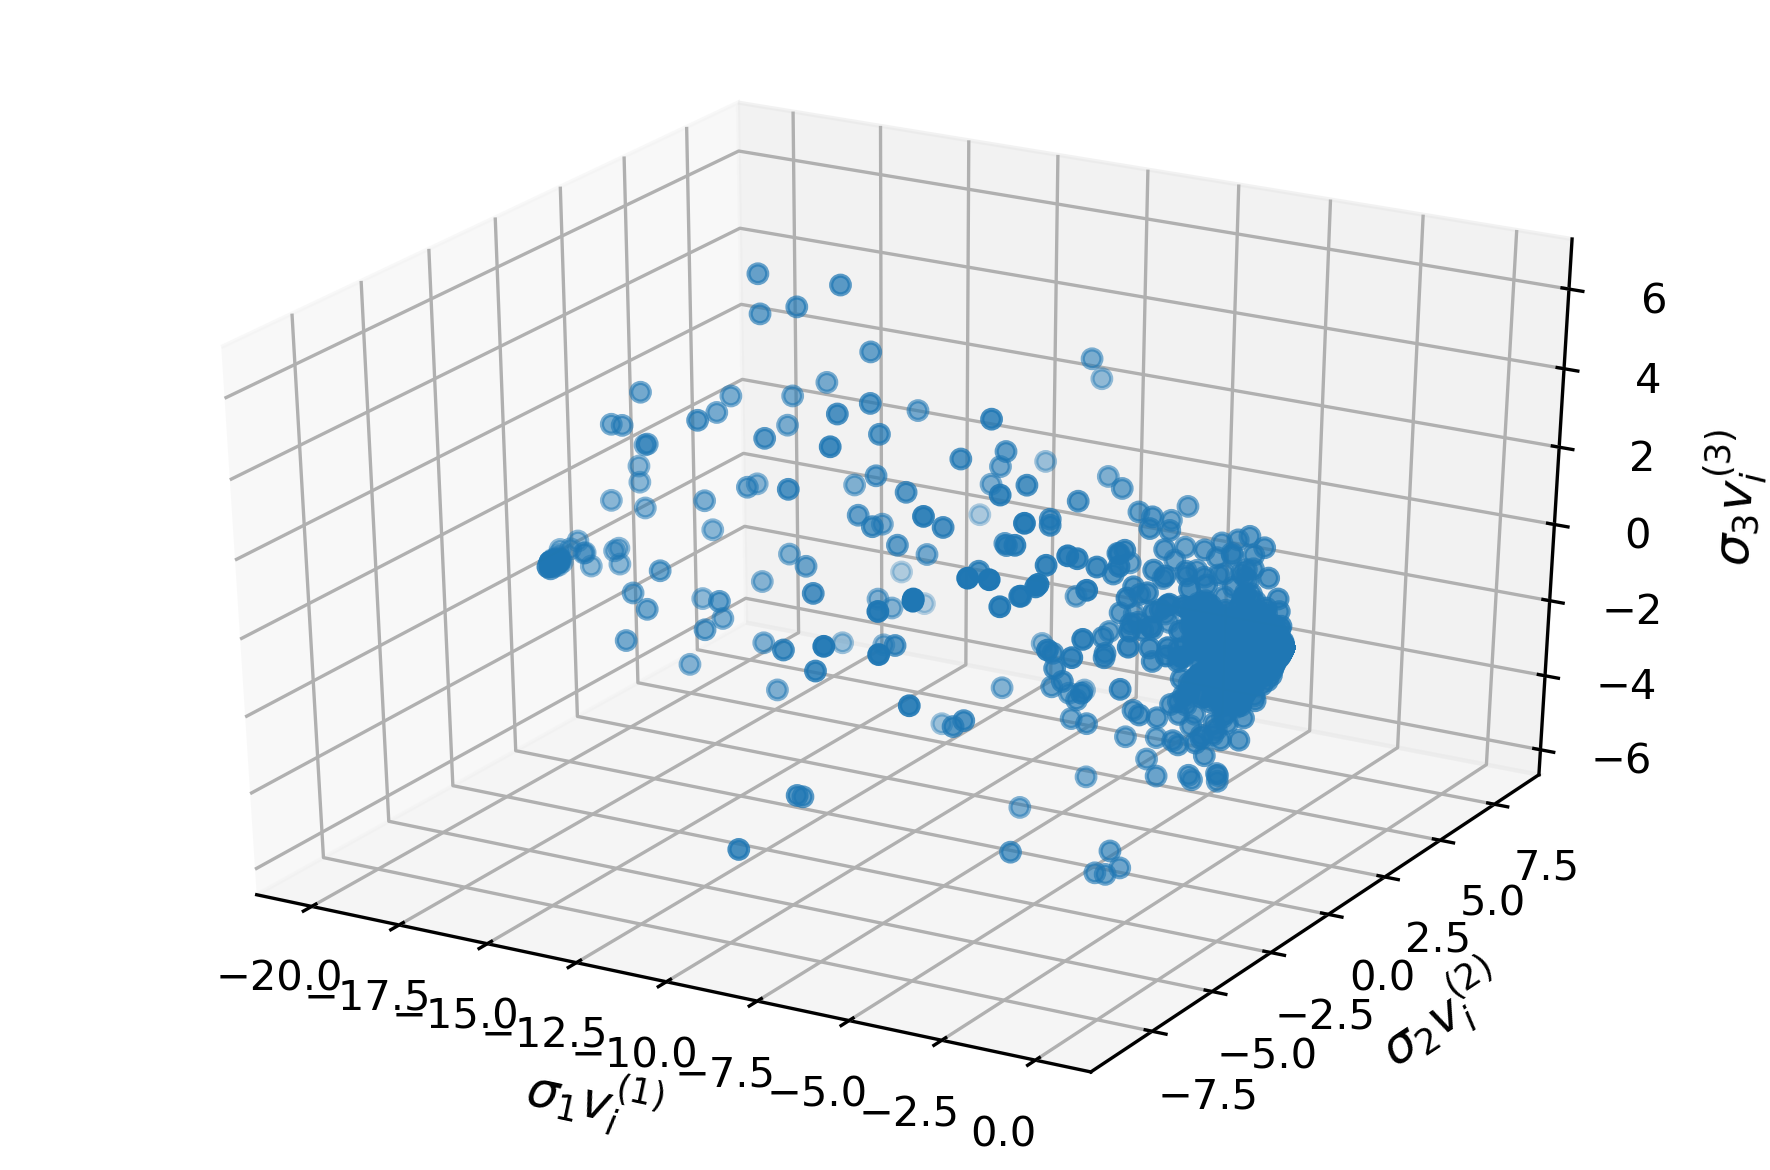

In [14]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(S_F[0]*VT_F.transpose()[:,0], S_F[1]*VT_F.transpose()[:,1], S_F[2]*VT_F.transpose()[:,2], marker = 'o')

ax.set_xlabel(f"$\sigma_{{{1}}} v_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} v_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} v_i^{{({3})}}$", fontsize=12)

plt.tight_layout()

make_movies = False
if make_movies:
    imagedata = []
    for ii in range(0,360,1):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)
        data = imageio.imread('movie{}.png'.format(ii))
        imagedata.append(data)
    imageio.mimwrite('rnaseH_tree_res.mp4', imagedata, format= '.mp4', fps = 20)



## 10. Create a data frame of $V^{(i)}$ (sequence) values and sort--here the work is done with a function.
This allows the eigenvalue number i to be passed in.

In [ ]:
def sort_vi(i, VT_F):
    aas_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 
                'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    ohe_length = len(VT_F.transpose()[:, i-1])
    seq_length = ohe_length/20

    # Create a position vector
    ohe_index_vector = np.arange(0, ohe_length)
    ohe_posn_vector = np.zeros((ohe_length, 1))
    for index in ohe_index_vector:
        ohe_posn_vector[index] = index//20 + 1

    # Create a residue vector
    ohe_resi_list = []
    posn = 1
    while posn <= seq_length:
        ohe_resi_list.append(aas_list)
        posn += 1
    ohe_resi_list_flat = []
    for sublist in ohe_resi_list:
        for item in sublist:
            ohe_resi_list_flat.append(item)
    ohe_resi_array = np.array(ohe_resi_list_flat)
    ohe_resi_array = np.reshape(ohe_resi_array, (ohe_length, 1))

    # Create data frame
    col_heads = ['position', 'residue', f'v^({i})']
    vi_df = pd.DataFrame(np.zeros((ohe_length, 3)), columns = col_heads)
    vi_df['position'] = ohe_posn_vector
    vi_df['residue'] = ohe_resi_array
    vi_df[f'v^({i})'] = VT_F.transpose()[:,i]

    # Sort to a new data frame
    vi_sorted_high_df = vi_df.sort_values(f'v^({i})', ascending = False)
    vi_sorted_low_df = vi_df.sort_values(f'v^({i})', ascending = True)
    
    return vi_df, vi_sorted_high_df, vi_sorted_low_df

In [ ]:
v1_df, v1_sorted_high_df, v1_sorted_low_df = sort_vi(1, VT_F)
v2_df, v2_sorted_high_df, v2_sorted_low_df = sort_vi(2, VT_F)

In [ ]:
v2_sorted_high_df[0:20]

In [ ]:
v2_sorted_low_df[0:20]

In [ ]:
v2_top_100_df = v2_sorted_df[0:100]
v2_top_100_df.sort_values('position')

## 12. k-means clustering
Use the first three singular vectors.

In [64]:
from sklearn.cluster import KMeans

X = np.zeros((len(U_F), 3))
X[:,0] = S_F[0]*U_F[:,0]
X[:,1] = S_F[1]*U_F[:,1]
X[:,2] = S_F[2]*U_F[:,2]

k = 5

np.random.seed(634)
kmeans = KMeans(n_clusters = k)
y_pred = kmeans.fit_predict(X)

In [65]:
kmeans_df = pd.DataFrame(X, columns = ['sigma_1*u(1)', 'sigma_2*u(2)','sigma_3*u(3)'])
kmeans_df['cluster'] = y_pred

In [66]:
kmeans_df

sigma_1*u(1)  sigma_2*u(2)  sigma_3*u(3)  cluster
0        7.646504      1.090094      1.647370        0
1        7.356196     -0.240431      2.002326        0
2        7.563034     -0.589767      1.678829        1
3        7.747276     -0.866180      2.525242        4
4        7.611609      0.799122      3.298620        4
..            ...           ...           ...      ...
404      7.678507      2.078952      2.337581        0
405      2.967766     -0.222472      0.926269        0
406      3.675457     -0.448808      2.137520        0
407      4.341474     -0.286144      1.929401        0
408      3.575402     -0.241884      0.870323        0

[409 rows x 4 columns]

## 13. Plotting the 409 sequences in the MSA, colored by cluster, in terms of $u_i^{(1)}$, $u_i^{(2)}$, and $u_i^{(3)}$.

In [67]:
is_cluster_0 = kmeans_df['cluster'] == 0
is_cluster_1 = kmeans_df['cluster'] == 1
is_cluster_2 = kmeans_df['cluster'] == 2
is_cluster_3 = kmeans_df['cluster'] == 3
is_cluster_4 = kmeans_df['cluster'] == 4

kmeans_cluster_0_df = kmeans_df[is_cluster_0]
kmeans_cluster_1_df = kmeans_df[is_cluster_1]
kmeans_cluster_2_df = kmeans_df[is_cluster_2]
kmeans_cluster_3_df = kmeans_df[is_cluster_3]
kmeans_cluster_4_df = kmeans_df[is_cluster_4]

In [16]:
kmeans_cluster_0_df

sigma_1*u(1)  sigma_2*u(2)  sigma_3*u(3)  cluster
0        7.646504      1.090094      1.647370        0
1        7.356196     -0.240431      2.002326        0
38       6.870104      1.252371      2.966306        0
39       7.634538     -0.013906      1.977354        0
40       7.186618      1.069243      1.678345        0
..            ...           ...           ...      ...
404      7.678507      2.078952      2.337581        0
405      2.967766     -0.222472      0.926269        0
406      3.675457     -0.448808      2.137520        0
407      4.341474     -0.286144      1.929401        0
408      3.575402     -0.241884      0.870323        0

[68 rows x 4 columns]

In [72]:
len(kmeans_cluster_4_df)

36

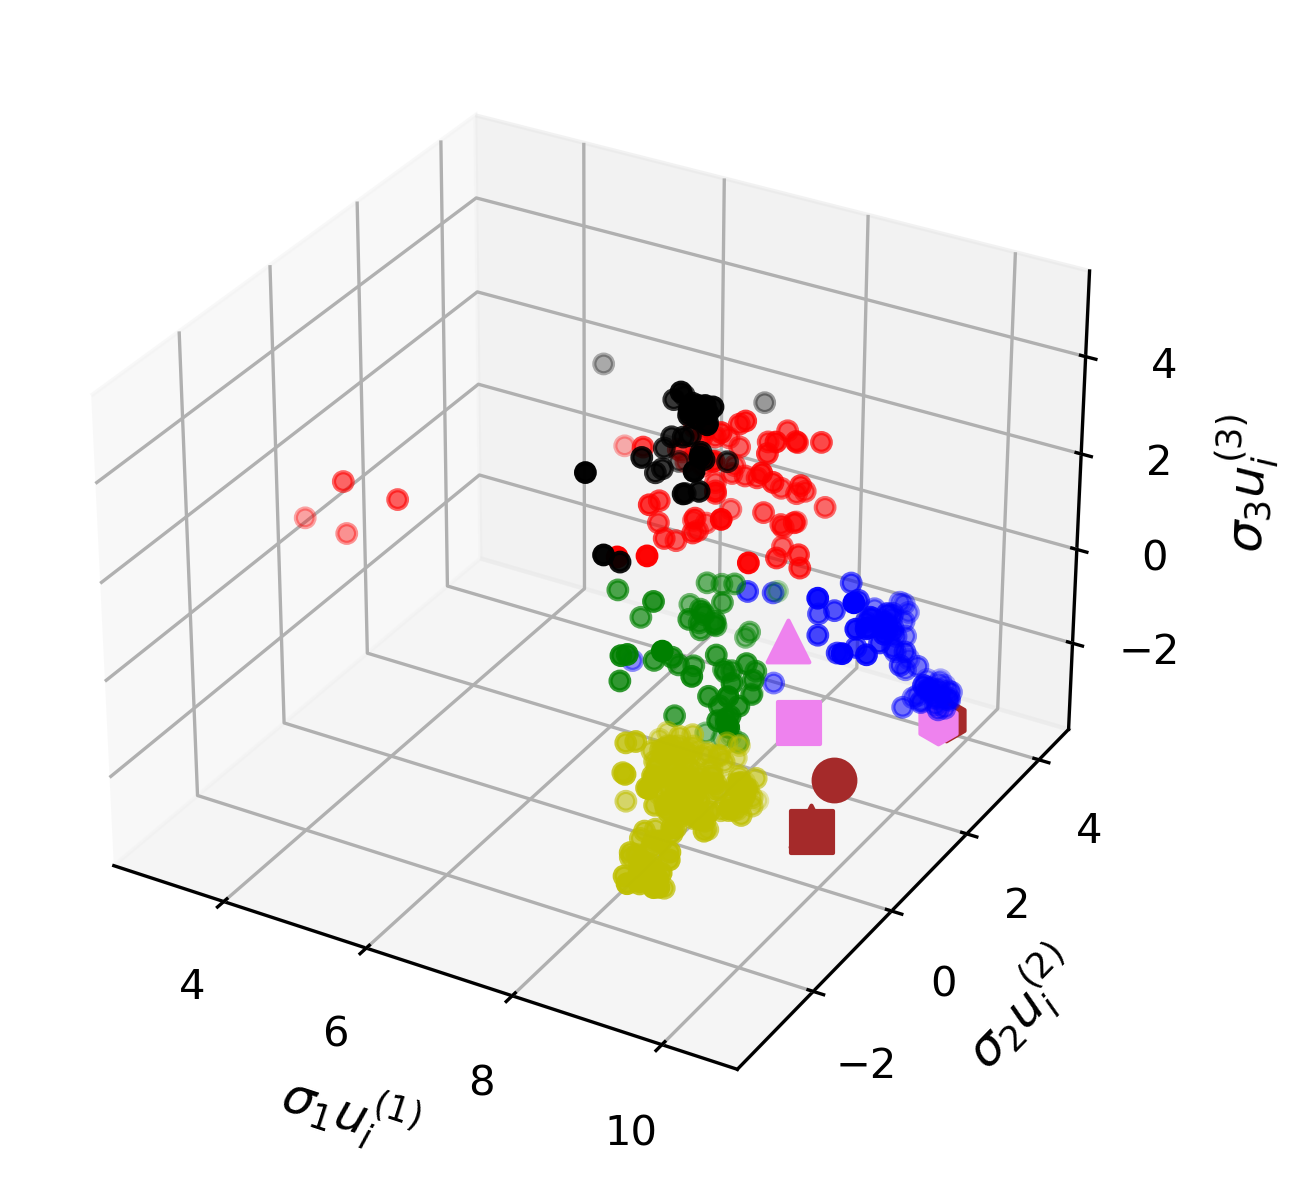

In [46]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

#ax.scatter(consensus_usig_i[0], consensus_usig_i[1], consensus_usig_i[2], 
           #c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_kmeans.pdf')

make_movies = False
if make_movies:
    imagedata = []
    for ii in range(0,360,1):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)
        data = imageio.imread('movie{}.png'.format(ii))
        imagedata.append(data)

    imageio.mimwrite('rnaseH_tree_seq_kmeans.mp4', imagedata, format= '.mp4', fps = 20)

## 2D plots of sequences colored by clusters (including ancestors)

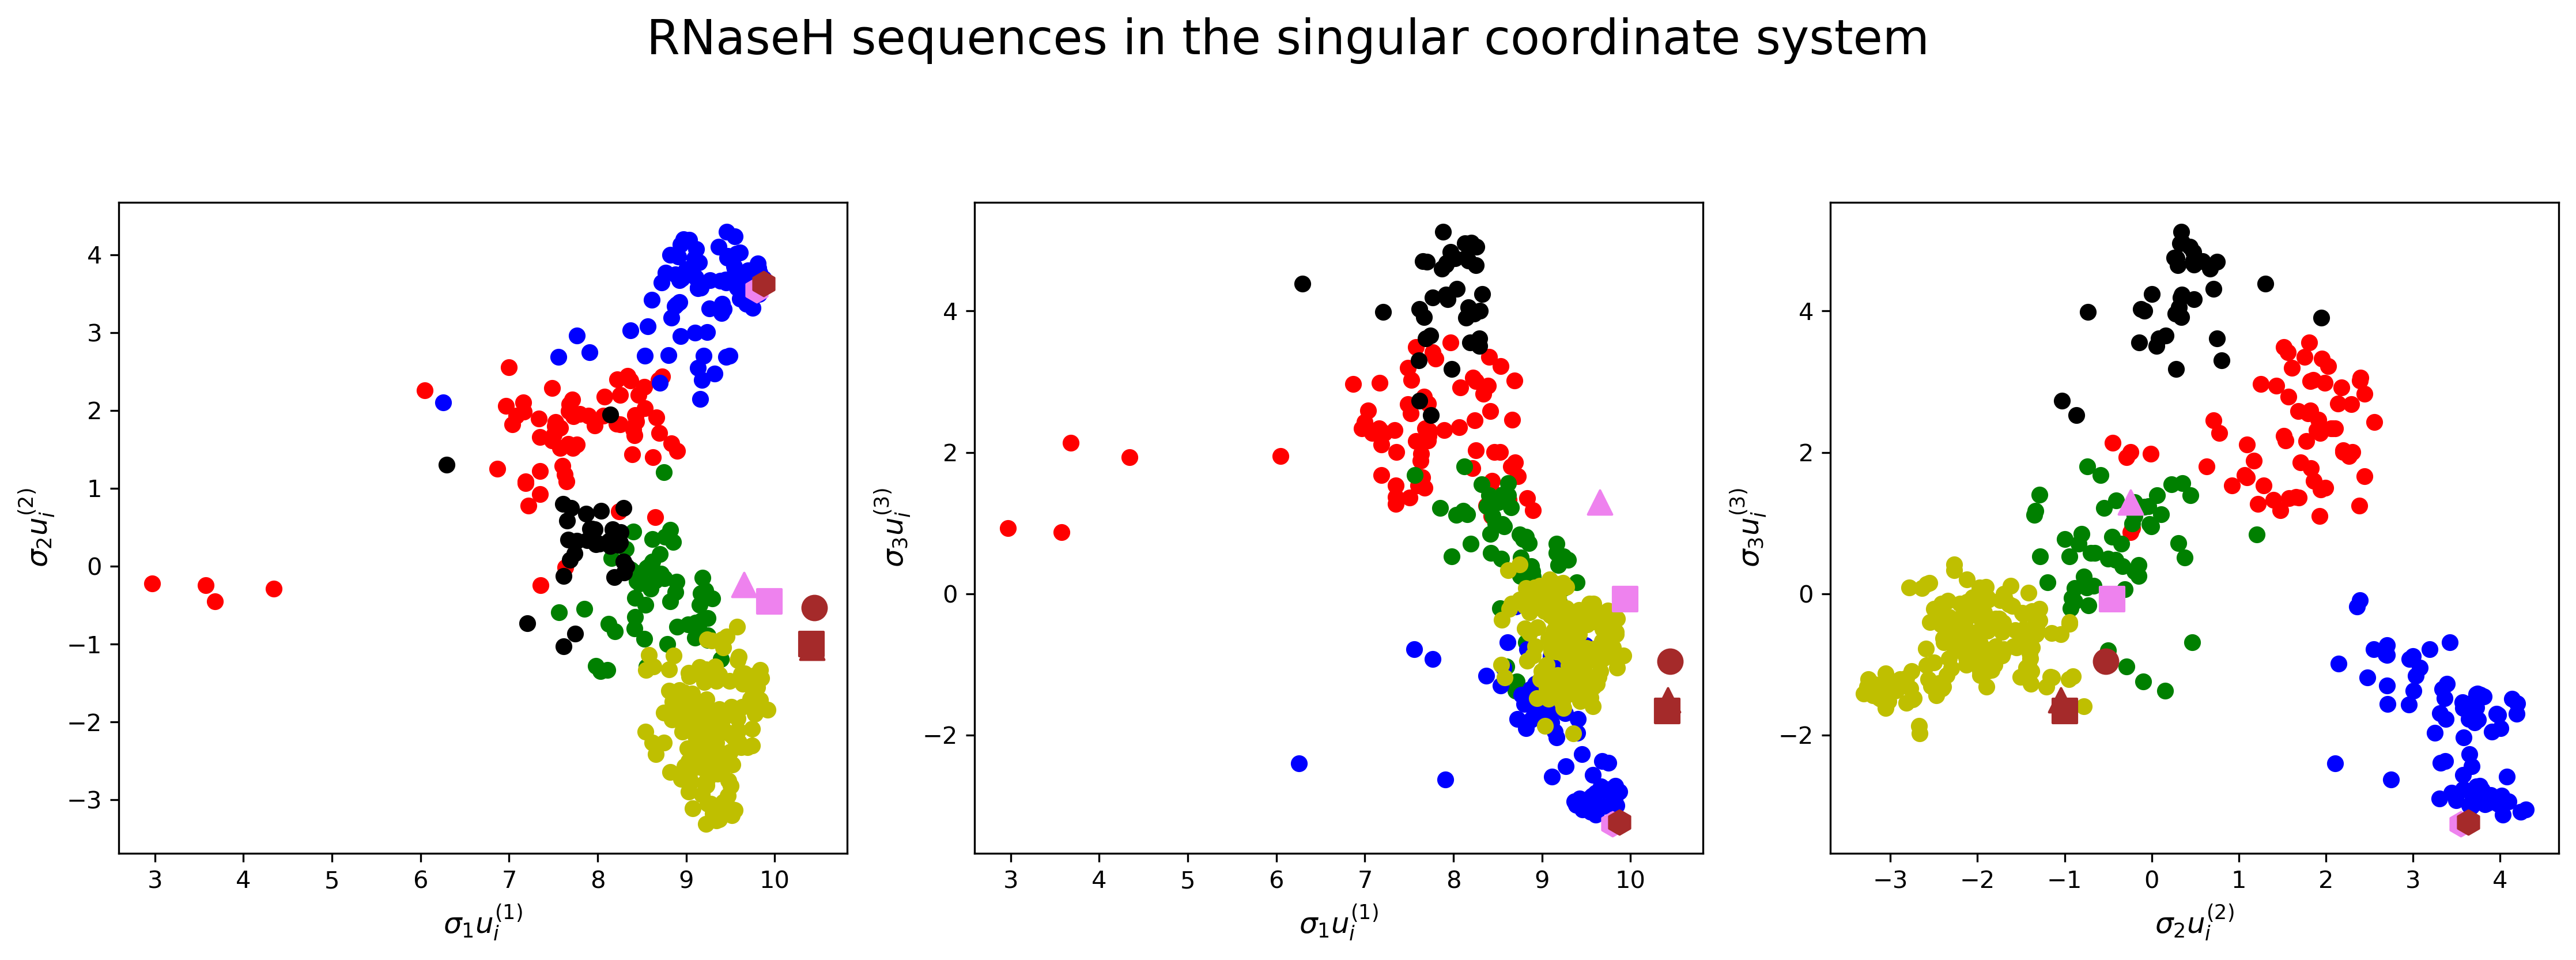

In [47]:
fig = plt.figure(dpi=300, figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), c='r')
ax1.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), c='g')
ax1.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), c='b')
ax1.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), c='y')
ax1.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), c='k')
ax1.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][1], 
           c='violet', s=100, marker='^')
ax1.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][1], 
           c='violet', s=100, marker='s')
ax1.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][1], 
           c='violet', s=100, marker='h')
ax1.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][1], 
           c='brown', s=100, marker='o')
ax1.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           c='brown', s=100, marker='^')
ax1.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][1], 
           c='brown', s=100, marker='s')
ax1.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][1], 
           c='brown', s=100, marker='h')
#ax1.scatter(consensus_usig_i[0], consensus_usig_i[1], c='r', s=250, marker='*')

ax1.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax1.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)

ax2.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')
ax2.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')
ax2.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')
ax2.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')
ax2.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')
ax2.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][2], 
           c='violet', s=100, marker='^')
ax2.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][2], 
           c='violet', s=100, marker='s')
ax2.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][2], 
           c='violet', s=100, marker='h')
ax2.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][2], 
           c='brown', s=100, marker='o')
ax2.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][2], 
           c='brown', s=100, marker='^')
ax2.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][2], 
           c='brown', s=100, marker='s')
ax2.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][2], 
           c='brown', s=100, marker='h')
#ax2.scatter(consensus_usig_i[0], consensus_usig_i[2], c='r', s=250, marker='*')

ax2.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax2.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

ax3.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')
ax3.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')
ax3.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')
ax3.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')
ax3.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')
ax3.scatter(anc_cons_usig_i_dict['>Anc1*'][1], anc_cons_usig_i_dict['>Anc1*'][2], 
           c='violet', s=100, marker='^')
ax3.scatter(anc_cons_usig_i_dict['>AncA*'][1], anc_cons_usig_i_dict['>AncA*'][2], 
           c='violet', s=100, marker='s')
ax3.scatter(anc_cons_usig_i_dict['>AncC*'][1], anc_cons_usig_i_dict['>AncC*'][2], 
           c='violet', s=100, marker='h')
ax3.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], anc_cons_usig_i_dict['>WholeCons*'][2], 
           c='brown', s=100, marker='o')
ax3.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], anc_cons_usig_i_dict['>Anc1Cons*'][2], 
           c='brown', s=100, marker='^')
ax3.scatter(anc_cons_usig_i_dict['>AncACons*'][1], anc_cons_usig_i_dict['>AncACons*'][2], 
           c='brown', s=100, marker='s')
ax3.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], anc_cons_usig_i_dict['>AncCCons*'][2], 
           c='brown', s=100, marker='h')
#ax3.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax3.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax3.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)
plt.suptitle('RNaseH sequences in the singular coordinate system', y = 1.1, fontsize=20)

plt.tight_layout()
plt.savefig('RNH_u123.pdf')

## Identify the AncA sequences that Mike sent

In [16]:
AncA_seqs_not_aligned, AncA_names = alignment_sequences('anca-descendants.fasta')

print(f'The number of AncA descendant sequences is {len(AncA_names)}.')

AncA_seqs_aligned = []
AncA_indices = []
AncA_names_from_RNtree = []

# The loop below gets the indices of sequences in the MSA that are in AncA
i = 0
for name in RNtree_names:
    for AncA_name in AncA_names:
        if name == AncA_name:
            AncA_seqs_aligned.append(RNtree[i])
            AncA_indices.append(i)
            AncA_names_from_RNtree.append(RNtree_names[i])
    i += 1

AncA_seqs_ohe = ohe_msa(AncA_seqs_aligned)

# Below, three numpy vectors are built that contain U(i)*sigi (=F dot VT(i))
AncA_extant_usig1 = np.zeros(len(AncA_names))
AncA_extant_usig2 = np.zeros(len(AncA_names))
AncA_extant_usig3 = np.zeros(len(AncA_names))

i = 0
for seq_ohe in AncA_seqs_ohe:
    AncA_extant_usig1[i] = np.matmul(seq_ohe, VT_F.transpose()[:,0])
    AncA_extant_usig2[i] = np.matmul(seq_ohe, VT_F.transpose()[:,1])
    AncA_extant_usig3[i] = np.matmul(seq_ohe, VT_F.transpose()[:,2])
    i += 1

The number of AncA descendant sequences is 298.


## Identify the AncB sequences that Mike sent

In [17]:
AncB_seqs_not_aligned, AncB_names = alignment_sequences('ancb-descendants.fasta')

print(f'The number of AncB descendant sequences is {len(AncB_names)}.')

AncB_seqs_aligned = []
AncB_indices = []
AncB_names_from_RNtree = []

# The loop below gets the indices of sequences in the MSA that are in AncA
i = 0
for name in RNtree_names:
    for AncB_name in AncB_names:
        if name == AncB_name:
            AncB_seqs_aligned.append(RNtree[i])
            AncB_indices.append(i)
            AncB_names_from_RNtree.append(RNtree_names[i])
    i += 1

AncB_seqs_ohe = ohe_msa(AncB_seqs_aligned)

# Below, three numpy vectors are built that contain U(i)*sigi (=F dot VT(i))
AncB_extant_usig1 = np.zeros(len(AncB_names))
AncB_extant_usig2 = np.zeros(len(AncB_names))
AncB_extant_usig3 = np.zeros(len(AncB_names))

i = 0
for seq_ohe in AncB_seqs_ohe:
    AncB_extant_usig1[i] = np.matmul(seq_ohe, VT_F.transpose()[:,0])
    AncB_extant_usig2[i] = np.matmul(seq_ohe, VT_F.transpose()[:,1])
    AncB_extant_usig3[i] = np.matmul(seq_ohe, VT_F.transpose()[:,2])
    i += 1

The number of AncB descendant sequences is 79.


## Identify the AncC sequences that Mike sent

In [18]:
AncC_seqs_not_aligned, AncC_names = alignment_sequences('AncC-descendants.fasta')

print(f'The number of AncC descendant sequences is {len(AncC_names)}.')

AncC_seqs_aligned = []
AncC_indices = []
AncC_names_from_RNtree = []

# The loop below gets the indices of sequences in the MSA that are in AncC
i = 0
for name in RNtree_names:
    for AncC_name in AncC_names:
        if name == AncC_name:
            AncC_seqs_aligned.append(RNtree[i])
            AncC_indices.append(i)
            AncC_names_from_RNtree.append(RNtree_names[i])
    i += 1

AncC_seqs_ohe = ohe_msa(AncC_seqs_aligned)

# Below, three numpy vectors are built that contain U(i)*sigi (=F dot VT(i))
AncC_extant_usig1 = np.zeros(len(AncC_names))
AncC_extant_usig2 = np.zeros(len(AncC_names))
AncC_extant_usig3 = np.zeros(len(AncC_names))

i = 0
for seq_ohe in AncC_seqs_ohe:
    AncC_extant_usig1[i] = np.matmul(seq_ohe, VT_F.transpose()[:,0])
    AncC_extant_usig2[i] = np.matmul(seq_ohe, VT_F.transpose()[:,1])
    AncC_extant_usig3[i] = np.matmul(seq_ohe, VT_F.transpose()[:,2])
    i += 1

The number of AncC descendant sequences is 18.


## Identify the AncD sequences that Mike sent

In [19]:
AncD_seqs_not_aligned, AncD_names = alignment_sequences('AncD-descendants.fasta')

print(f'The number of AncD descendant sequences is {len(AncD_names)}.')

AncD_seqs_aligned = []
AncD_indices = []
AncD_names_from_RNtree = []

# The loop below gets the indices of sequences in the MSA that are in AncD
i = 0
for name in RNtree_names:
    for AncD_name in AncD_names:
        if name == AncD_name:
            AncD_seqs_aligned.append(RNtree[i])
            AncD_indices.append(i)
            AncD_names_from_RNtree.append(RNtree_names[i])
    i += 1

AncD_seqs_ohe = ohe_msa(AncD_seqs_aligned)

# Below, three numpy vectors are built that contain U(i)*sigi (=F dot VT(i))
AncD_extant_usig1 = np.zeros(len(AncD_names))
AncD_extant_usig2 = np.zeros(len(AncD_names))
AncD_extant_usig3 = np.zeros(len(AncD_names))

i = 0
for seq_ohe in AncD_seqs_ohe:
    AncD_extant_usig1[i] = np.matmul(seq_ohe, VT_F.transpose()[:,0])
    AncD_extant_usig2[i] = np.matmul(seq_ohe, VT_F.transpose()[:,1])
    AncD_extant_usig3[i] = np.matmul(seq_ohe, VT_F.transpose()[:,2])
    i += 1

The number of AncD descendant sequences is 6.


## Identify the Anc1 sequences that Mike sent

In [20]:
Anc1_seqs_not_aligned, Anc1_names = alignment_sequences('anc1-descendants.fasta')

print(f'The number of Anc1 descendant sequences is {len(Anc1_names)}.')

Anc1_seqs_aligned = []
Anc1_indices = []
Anc1_names_from_RNtree = []

# The loop below gets the indices of sequences in the MSA that are in Anc1
i = 0
for name in RNtree_names:
    for Anc1_name in Anc1_names:
        if name == Anc1_name:
            Anc1_seqs_aligned.append(RNtree[i])
            Anc1_indices.append(i)
            Anc1_names_from_RNtree.append(RNtree_names[i])
    i += 1

Anc1_seqs_ohe = ohe_msa(Anc1_seqs_aligned)

# Below, three numpy vectors are built that contain U(i)*sigi (=F dot VT(i))
Anc1_extant_usig1 = np.zeros(len(Anc1_names))
Anc1_extant_usig2 = np.zeros(len(Anc1_names))
Anc1_extant_usig3 = np.zeros(len(Anc1_names))

i = 0
for seq_ohe in Anc1_seqs_ohe:
    Anc1_extant_usig1[i] = np.matmul(seq_ohe, VT_F.transpose()[:,0])
    Anc1_extant_usig2[i] = np.matmul(seq_ohe, VT_F.transpose()[:,1])
    Anc1_extant_usig3[i] = np.matmul(seq_ohe, VT_F.transpose()[:,2])
    i += 1

The number of Anc1 descendant sequences is 303.


## Identify the Anc2 sequences that Mike sent

In [21]:
Anc2_seqs_not_aligned, Anc2_names = alignment_sequences('Anc2-descendants.fasta')

print(f'The number of Anc2 descendant sequences is {len(Anc2_names)}.')

Anc2_seqs_aligned = []
Anc2_indices = []
Anc2_names_from_RNtree = []

# The loop below gets the indices of sequences in the MSA that are in Anc2
i = 0
for name in RNtree_names:
    for Anc2_name in Anc2_names:
        if name == Anc2_name:
            Anc2_seqs_aligned.append(RNtree[i])
            Anc2_indices.append(i)
            Anc2_names_from_RNtree.append(RNtree_names[i])
    i += 1

Anc2_seqs_ohe = ohe_msa(Anc2_seqs_aligned)

# Below, three numpy vectors are built that contain U(i)*sigi (=F dot VT(i))
Anc2_extant_usig1 = np.zeros(len(Anc2_names))
Anc2_extant_usig2 = np.zeros(len(Anc2_names))
Anc2_extant_usig3 = np.zeros(len(Anc2_names))

i = 0
for seq_ohe in Anc2_seqs_ohe:
    Anc2_extant_usig1[i] = np.matmul(seq_ohe, VT_F.transpose()[:,0])
    Anc2_extant_usig2[i] = np.matmul(seq_ohe, VT_F.transpose()[:,1])
    Anc2_extant_usig3[i] = np.matmul(seq_ohe, VT_F.transpose()[:,2])
    i += 1

The number of Anc2 descendant sequences is 5.


## Identify the Anc3 sequences that Mike sent

In [22]:
Anc3_seqs_not_aligned, Anc3_names = alignment_sequences('Anc3-descendants.fasta')

print(f'The number of Anc3 descendant sequences is {len(Anc3_names)}.')

Anc3_seqs_aligned = []
Anc3_indices = []
Anc3_names_from_RNtree = []

# The loop below gets the indices of sequences in the MSA that are in Anc3
i = 0
for name in RNtree_names:
    for Anc3_name in Anc3_names:
        if name == Anc3_name:
            Anc3_seqs_aligned.append(RNtree[i])
            Anc3_indices.append(i)
            Anc3_names_from_RNtree.append(RNtree_names[i])
    i += 1

Anc3_seqs_ohe = ohe_msa(Anc3_seqs_aligned)

# Below, three numpy vectors are built that contain U(i)*sigi (=F dot VT(i))
Anc3_extant_usig1 = np.zeros(len(Anc3_names))
Anc3_extant_usig2 = np.zeros(len(Anc3_names))
Anc3_extant_usig3 = np.zeros(len(Anc3_names))

i = 0
for seq_ohe in Anc3_seqs_ohe:
    Anc3_extant_usig1[i] = np.matmul(seq_ohe, VT_F.transpose()[:,0])
    Anc3_extant_usig2[i] = np.matmul(seq_ohe, VT_F.transpose()[:,1])
    Anc3_extant_usig3[i] = np.matmul(seq_ohe, VT_F.transpose()[:,2])
    i += 1

The number of Anc3 descendant sequences is 2.


## Subtractive group A_not_B

In [23]:
A_not_B_seqs_aligned = []
A_not_B_indices = []
A_not_B_names = []

# The loop below gets the indices of sequences in the MSA that are in AncA
i = 0
for AncA_name in AncA_names_from_RNtree:
    if AncA_name not in AncB_names_from_RNtree:
        A_not_B_seqs_aligned.append(AncA_seqs_aligned[i])
        A_not_B_indices.append(i)
        A_not_B_names.append(AncA_names_from_RNtree[i])
    i += 1

A_not_B_seqs_ohe = ohe_msa(A_not_B_seqs_aligned)

# Below, three numpy vectors are built that contain U(i)*sigi (=F dot VT(i))
A_not_B_extant_usig1 = np.zeros(len(A_not_B_names))
A_not_B_extant_usig2 = np.zeros(len(A_not_B_names))
A_not_B_extant_usig3 = np.zeros(len(A_not_B_names))

i = 0
for seq_ohe in A_not_B_seqs_ohe:
    A_not_B_extant_usig1[i] = np.matmul(seq_ohe, VT_F.transpose()[:,0])
    A_not_B_extant_usig2[i] = np.matmul(seq_ohe, VT_F.transpose()[:,1])
    A_not_B_extant_usig3[i] = np.matmul(seq_ohe, VT_F.transpose()[:,2])
    i += 1
    
print(f'The number of A_not_B descendant sequences is {len(A_not_B_names)}.')

The number of A_not_B descendant sequences is 219.


## Subtractive group B_not_C

In [24]:
B_not_C_seqs_aligned = []
B_not_C_indices = []
B_not_C_names = []

# The loop below gets the indices of sequences in the MSA that are in AncA
i = 0
for AncB_name in AncB_names_from_RNtree:
    if AncB_name not in AncC_names_from_RNtree:
        B_not_C_seqs_aligned.append(AncB_seqs_aligned[i])
        B_not_C_indices.append(i)
        B_not_C_names.append(AncB_names_from_RNtree[i])
    i += 1

B_not_C_seqs_ohe = ohe_msa(B_not_C_seqs_aligned)

# Below, three numpy vectors are built that contain U(i)*sigi (=F dot VT(i))
B_not_C_extant_usig1 = np.zeros(len(B_not_C_names))
B_not_C_extant_usig2 = np.zeros(len(B_not_C_names))
B_not_C_extant_usig3 = np.zeros(len(B_not_C_names))

i = 0
for seq_ohe in B_not_C_seqs_ohe:
    B_not_C_extant_usig1[i] = np.matmul(seq_ohe, VT_F.transpose()[:,0])
    B_not_C_extant_usig2[i] = np.matmul(seq_ohe, VT_F.transpose()[:,1])
    B_not_C_extant_usig3[i] = np.matmul(seq_ohe, VT_F.transpose()[:,2])
    i += 1
    
print(f'The number of B_not_C descendant sequences is {len(B_not_C_names)}.')

The number of B_not_C descendant sequences is 61.


## Subtractive group C_not_D

In [25]:
C_not_D_seqs_aligned = []
C_not_D_indices = []
C_not_D_names = []

# The loop below gets the indices of sequences in the MSA that are in AncA
i = 0
for AncC_name in AncC_names_from_RNtree:
    if AncC_name not in AncD_names_from_RNtree:
        C_not_D_seqs_aligned.append(AncC_seqs_aligned[i])
        C_not_D_indices.append(i)
        C_not_D_names.append(AncC_names_from_RNtree[i])
    i += 1

C_not_D_seqs_ohe = ohe_msa(C_not_D_seqs_aligned)

# Below, three numpy vectors are built that contain U(i)*sigi (=F dot VT(i))
C_not_D_extant_usig1 = np.zeros(len(C_not_D_names))
C_not_D_extant_usig2 = np.zeros(len(C_not_D_names))
C_not_D_extant_usig3 = np.zeros(len(C_not_D_names))

i = 0
for seq_ohe in C_not_D_seqs_ohe:
    C_not_D_extant_usig1[i] = np.matmul(seq_ohe, VT_F.transpose()[:,0])
    C_not_D_extant_usig2[i] = np.matmul(seq_ohe, VT_F.transpose()[:,1])
    C_not_D_extant_usig3[i] = np.matmul(seq_ohe, VT_F.transpose()[:,2])
    i += 1
    
print(f'The number of C_not_D descendant sequences is {len(C_not_D_names)}.')

The number of C_not_D descendant sequences is 12.


## Subtractive group 2_not_3

In [26]:
two_not_three_seqs_aligned = []
two_not_three_indices = []
two_not_three_names = []

# The loop below gets the indices of sequences in the MSA that are in AncA
i = 0
for Anc2_name in Anc2_names_from_RNtree:
    if Anc2_name not in Anc3_names_from_RNtree:
        two_not_three_seqs_aligned.append(Anc2_seqs_aligned[i])
        two_not_three_indices.append(i)
        two_not_three_names.append(Anc2_names_from_RNtree[i])
    i += 1

two_not_three_seqs_ohe = ohe_msa(two_not_three_seqs_aligned)

# Below, three numpy vectors are built that contain U(i)*sigi (=F dot VT(i))
two_not_three_extant_usig1 = np.zeros(len(two_not_three_names))
two_not_three_extant_usig2 = np.zeros(len(two_not_three_names))
two_not_three_extant_usig3 = np.zeros(len(two_not_three_names))

i = 0
for seq_ohe in two_not_three_seqs_ohe:
    two_not_three_extant_usig1[i] = np.matmul(seq_ohe, VT_F.transpose()[:,0])
    two_not_three_extant_usig2[i] = np.matmul(seq_ohe, VT_F.transpose()[:,1])
    two_not_three_extant_usig3[i] = np.matmul(seq_ohe, VT_F.transpose()[:,2])
    i += 1
    
print(f'The number of two_not_three descendant sequences is {len(two_not_three_names)}.')

The number of two_not_three descendant sequences is 3.


## AncA descendant plot, along withMSA clusters, ancestors and consensus sequences.

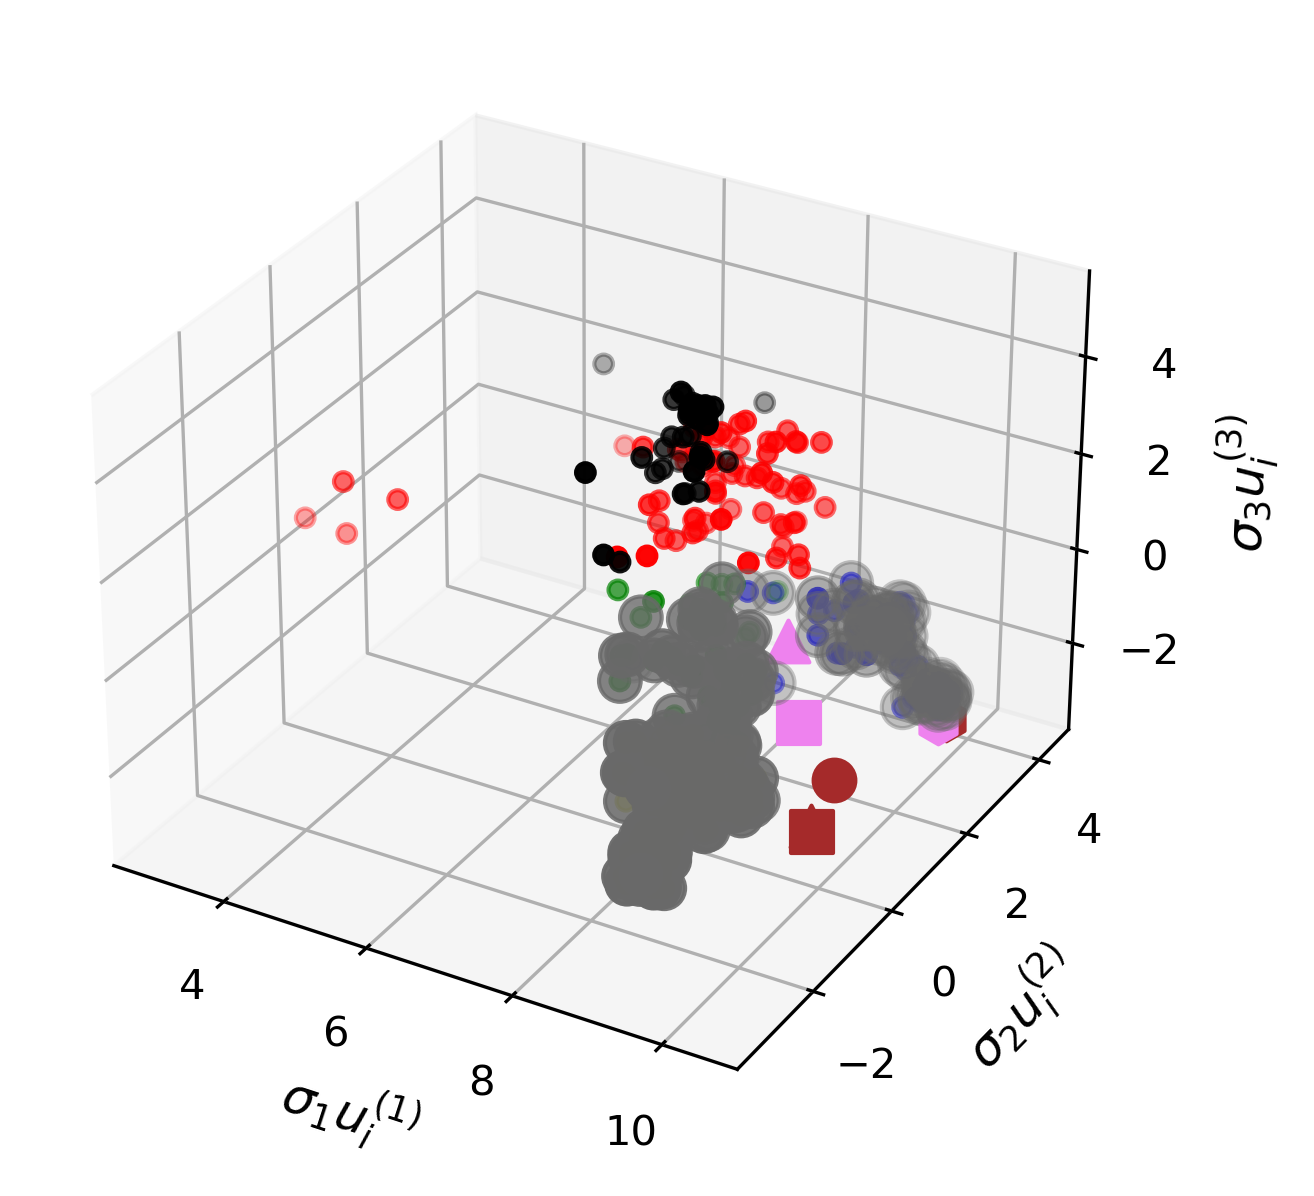

In [35]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

ax.scatter(AncA_extant_usig1, AncA_extant_usig2, 
           AncA_extant_usig3, c='dimgrey', s=100)

#ax.scatter(consensus_usig_i[0], consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_AncA_kmeans.pdf')

make_movies = False
if make_movies:
    imagedata = []
    for ii in range(0,360,1):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)
        data = imageio.imread('movie{}.png'.format(ii))
        imagedata.append(data)

    imageio.mimwrite('rnaseH_tree_seq_AncC_kmeans.mp4', imagedata, format= '.mp4', fps = 20)

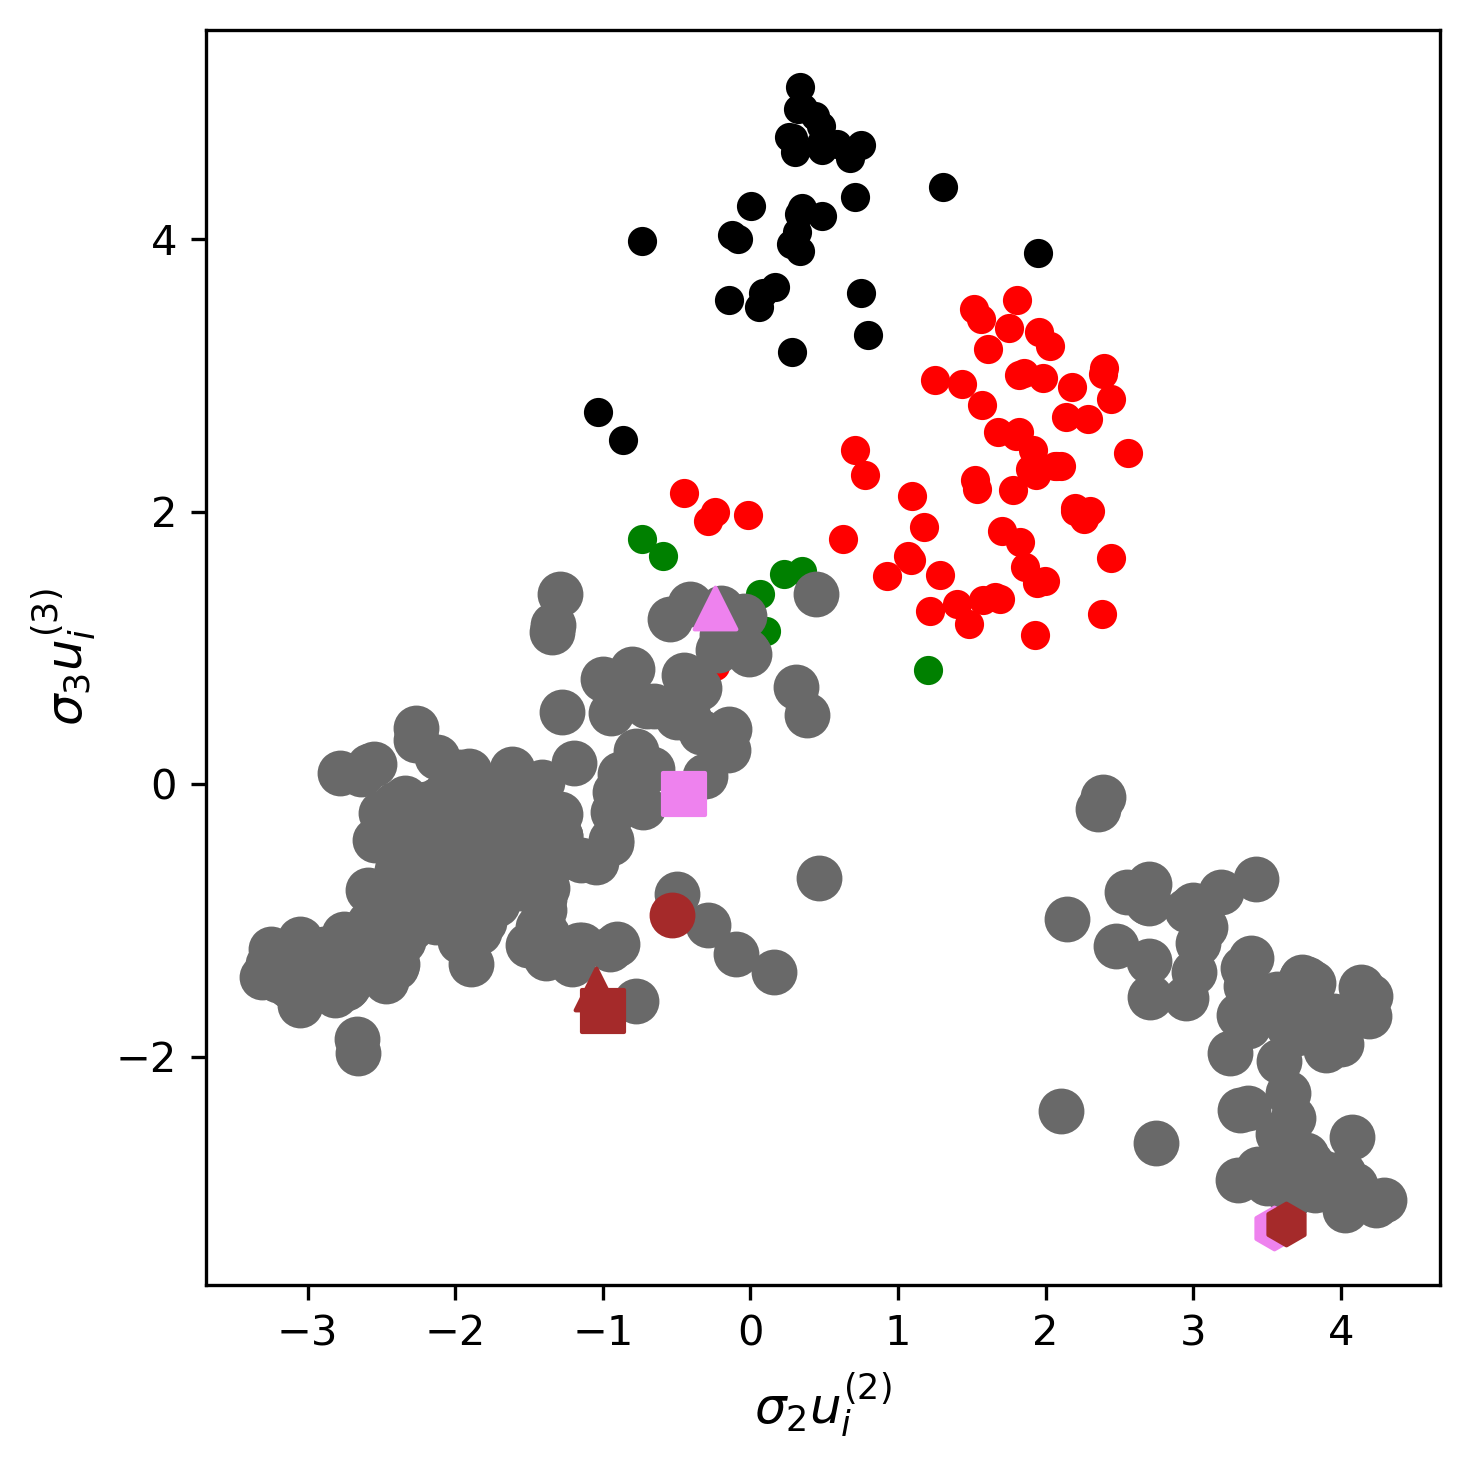

In [47]:
# 2d plot of AncA

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(AncA_extant_usig2, 
           AncA_extant_usig3, c='dimgrey', s=100)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')



#ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_kmeans_AncA_2d.pdf')

## AncB descendant plot, along withMSA clusters, ancestors and consensus sequences.

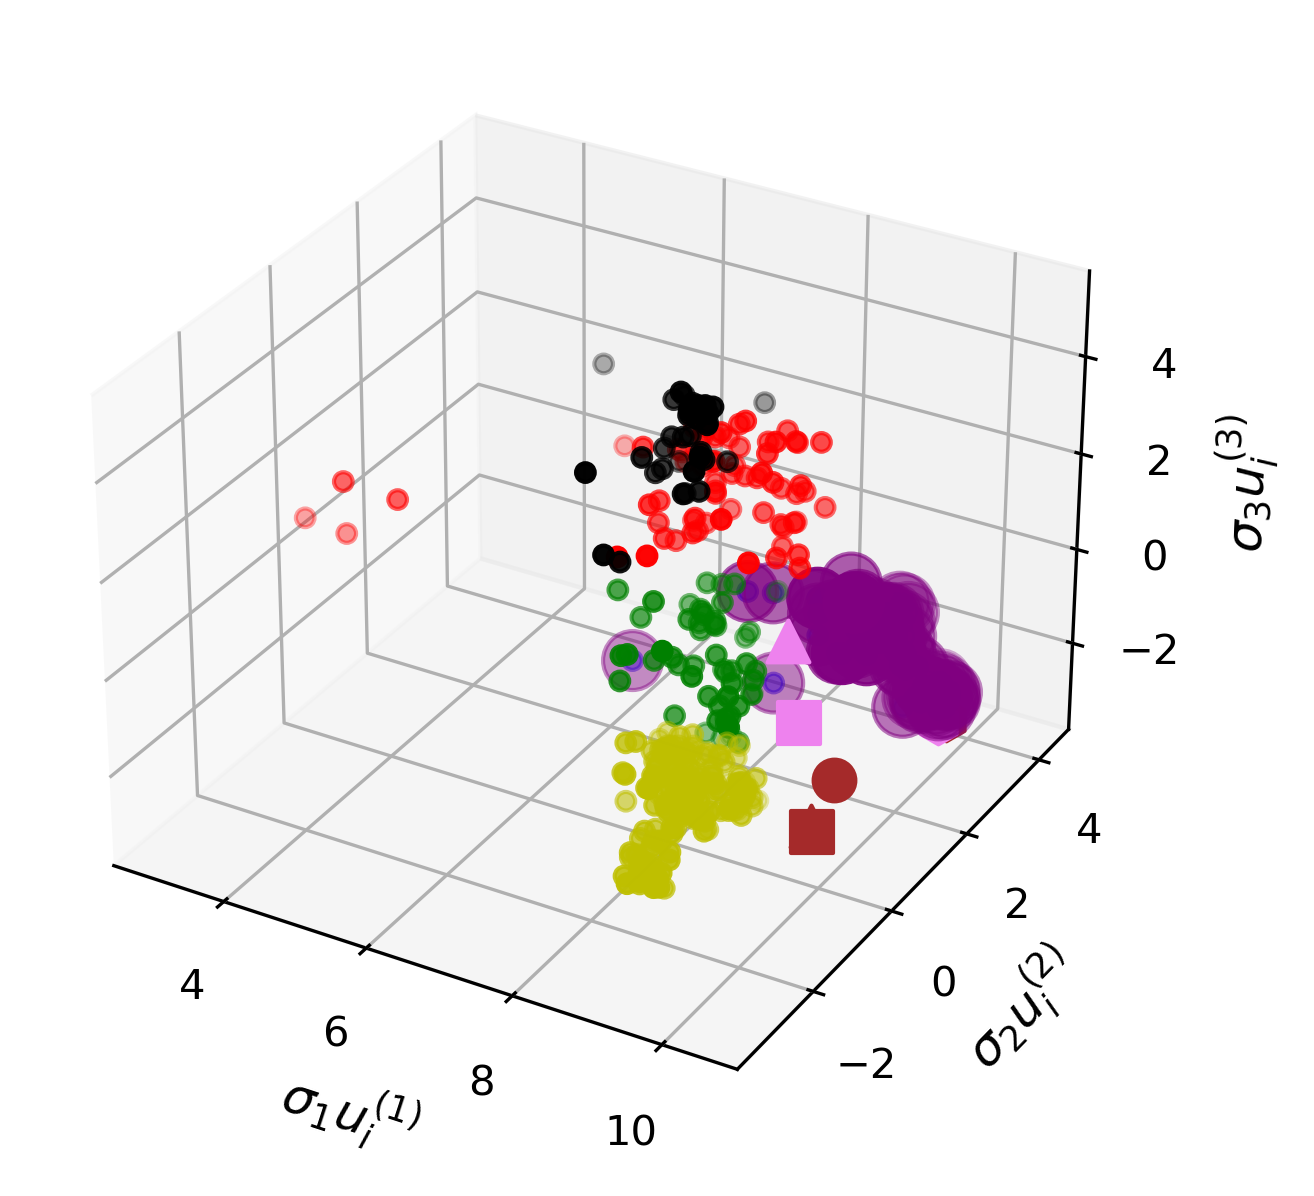

In [50]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

ax.scatter(AncB_extant_usig1, AncB_extant_usig2, 
           AncB_extant_usig3, c='purple', s=200)

#ax.scatter(consensus_usig_i[0], consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_AncB_kmeans.pdf')

make_movies = False
if make_movies:
    imagedata = []
    for ii in range(0,360,1):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)
        data = imageio.imread('movie{}.png'.format(ii))
        imagedata.append(data)

    imageio.mimwrite('rnaseH_tree_seq_AncC_kmeans.mp4', imagedata, format= '.mp4', fps = 20)

## AncC descendant plot, along withMSA clusters, ancestors and consensus sequences.

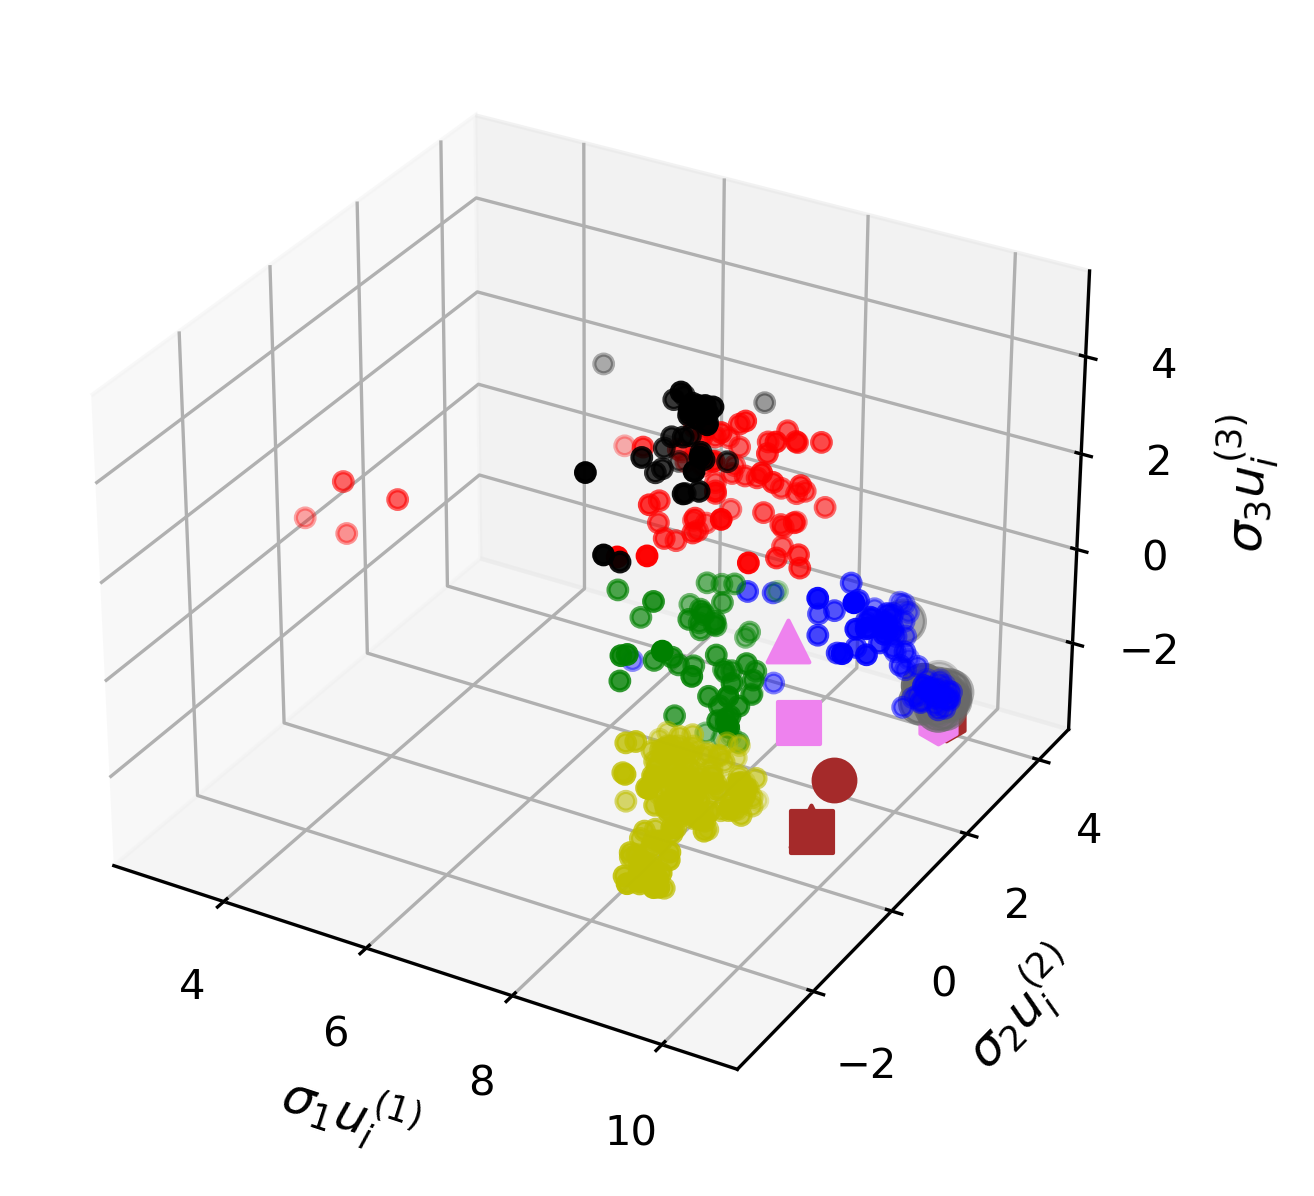

In [34]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(AncC_extant_usig1, AncC_extant_usig2, 
           AncC_extant_usig3, c='dimgrey', s=100)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

#ax.scatter(consensus_usig_i[0], consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_AncC_kmeans.pdf')

make_movies = False
if make_movies:
    imagedata = []
    for ii in range(0,360,1):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)
        data = imageio.imread('movie{}.png'.format(ii))
        imagedata.append(data)

    imageio.mimwrite('rnaseH_tree_seq_AncC_kmeans.mp4', imagedata, format= '.mp4', fps = 20)

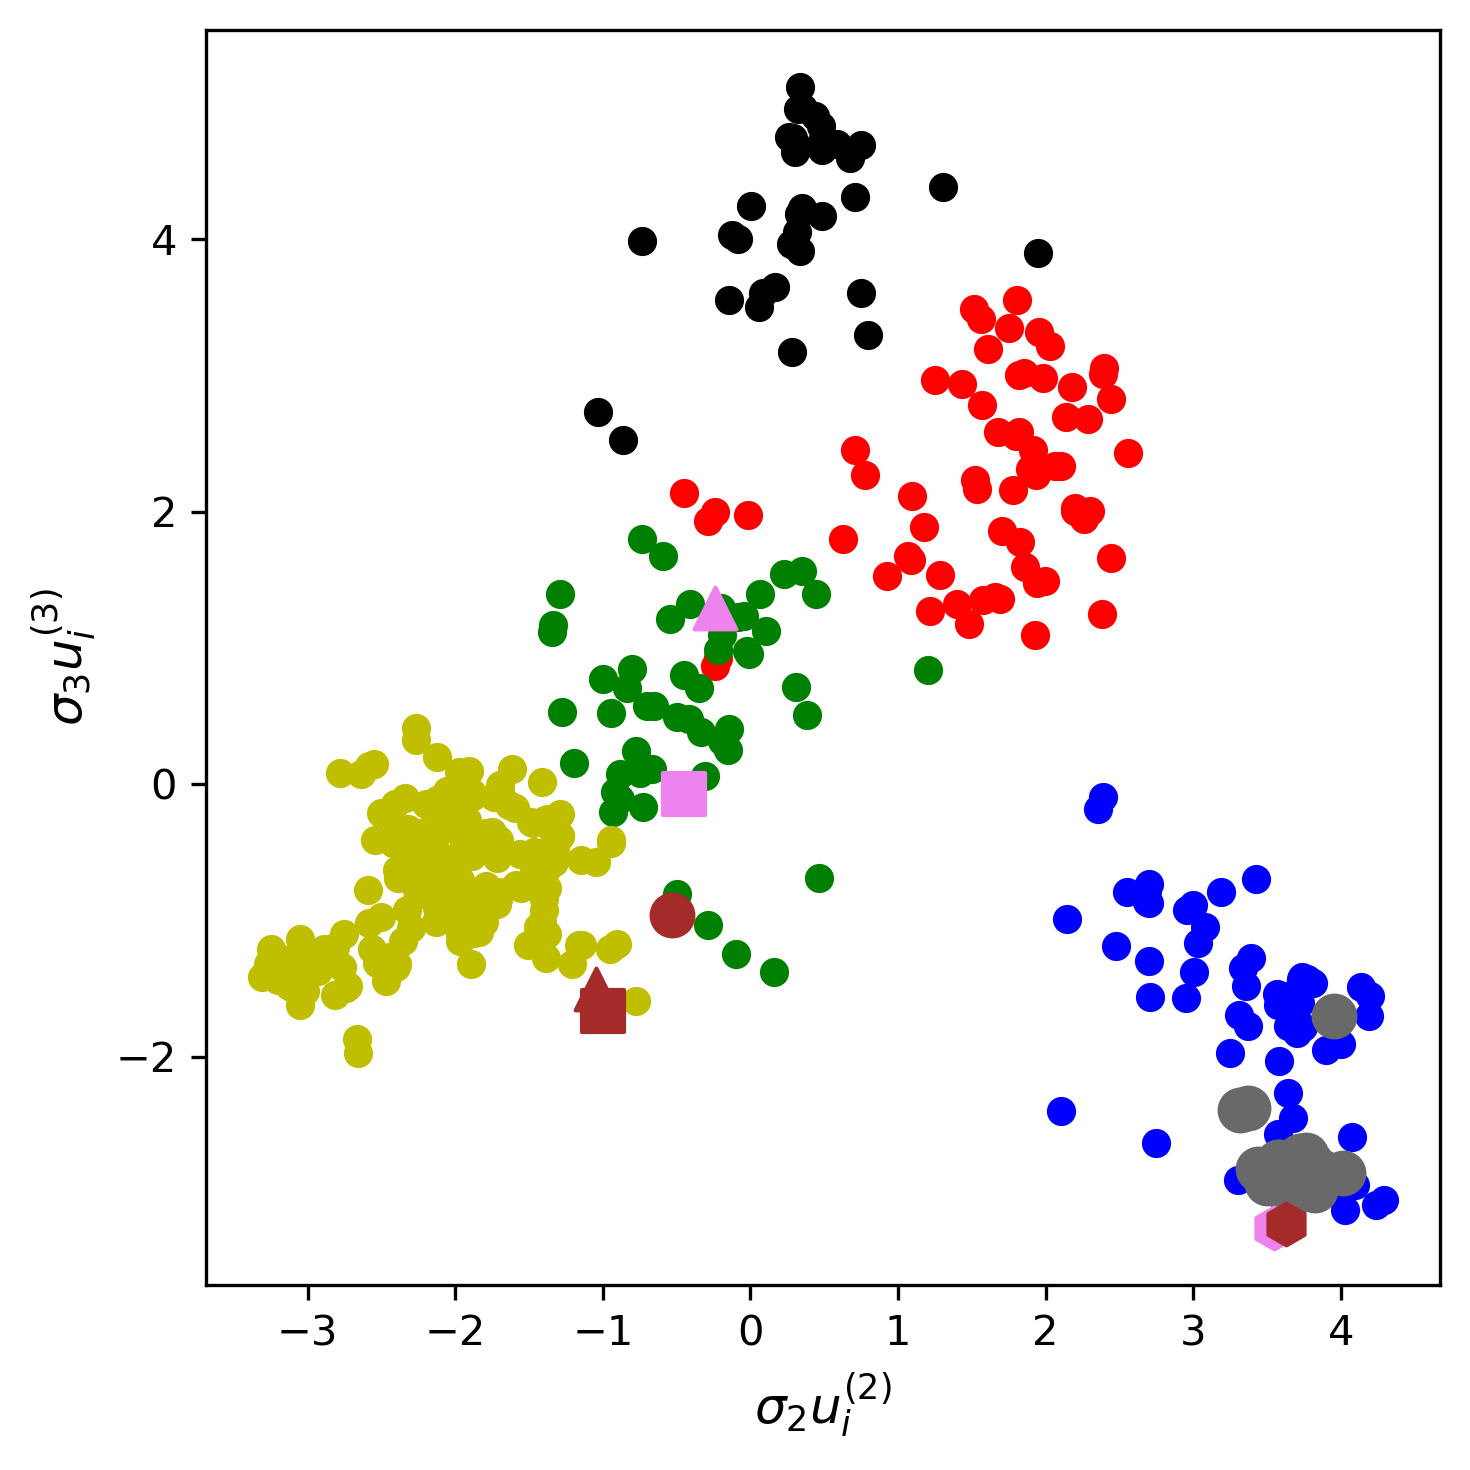

In [48]:
# 2d plot of AncC

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(AncC_extant_usig2, 
           AncC_extant_usig3, c='dimgrey', s=100)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')


#ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_kmeans_AncC_2d.pdf')

## AncD descendant plot, along withMSA clusters, ancestors and consensus sequences.

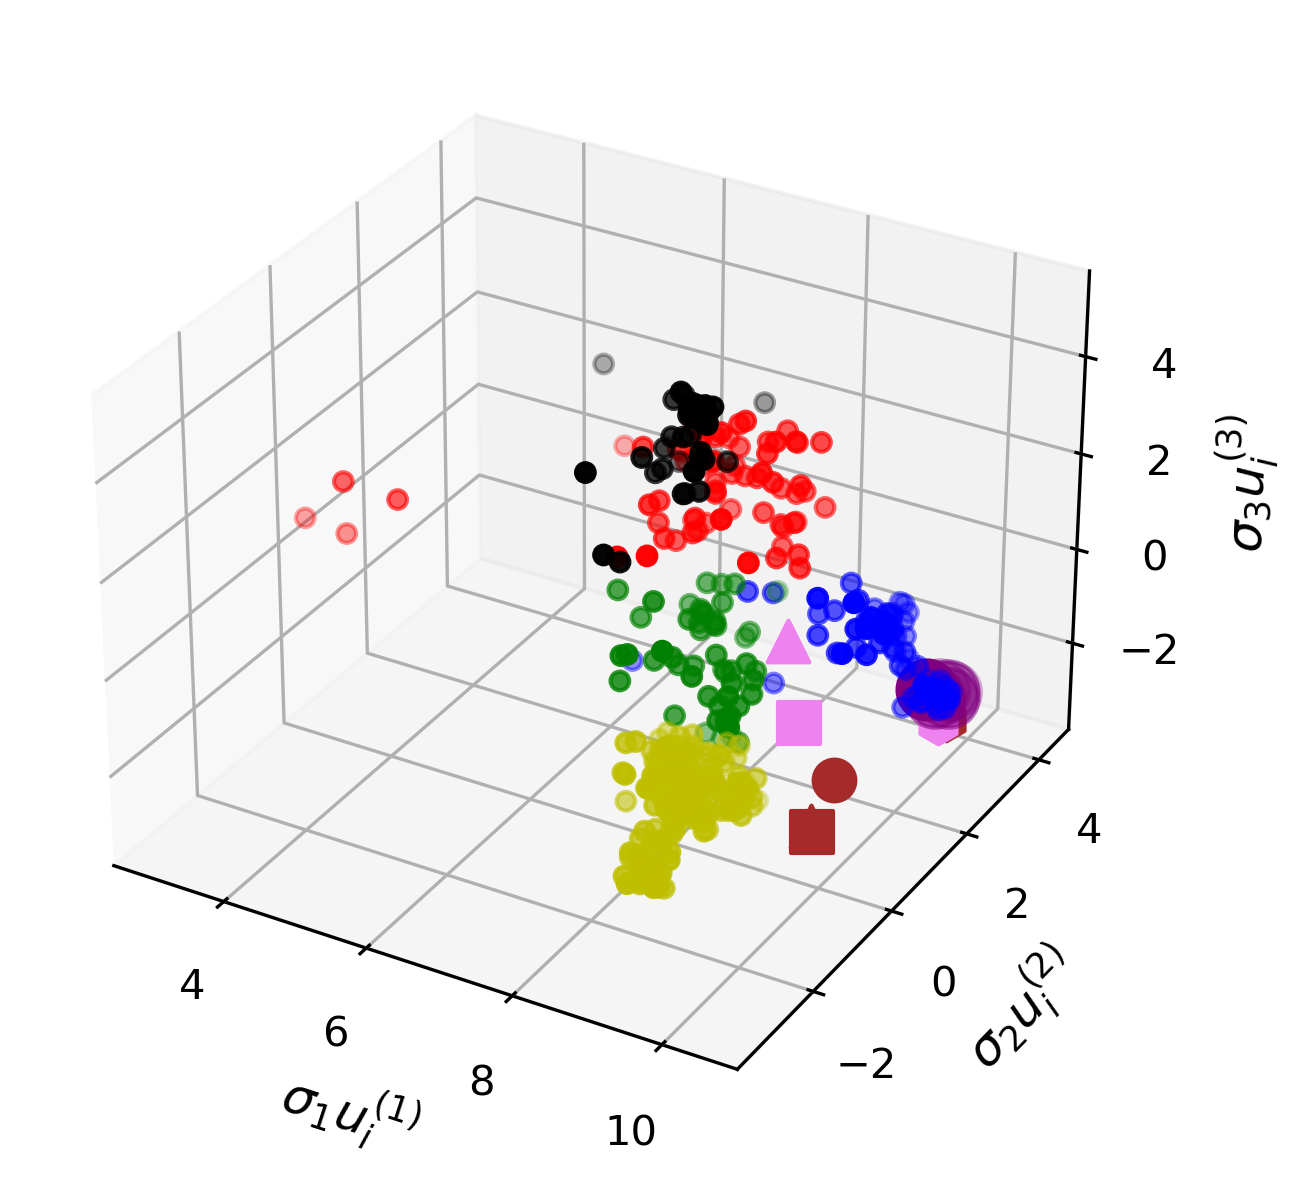

In [27]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

ax.scatter(AncD_extant_usig1, AncD_extant_usig2, 
           AncD_extant_usig3, c='purple', s=200)

#ax.scatter(consensus_usig_i[0], consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_AncD_kmeans.pdf')

make_movies = False
if make_movies:
    imagedata = []
    for ii in range(0,360,1):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)
        data = imageio.imread('movie{}.png'.format(ii))
        imagedata.append(data)

    imageio.mimwrite('rnaseH_tree_seq_AncC_kmeans.mp4', imagedata, format= '.mp4', fps = 20)

## Anc1 descendant plot, along withMSA clusters, ancestors and consensus sequences.

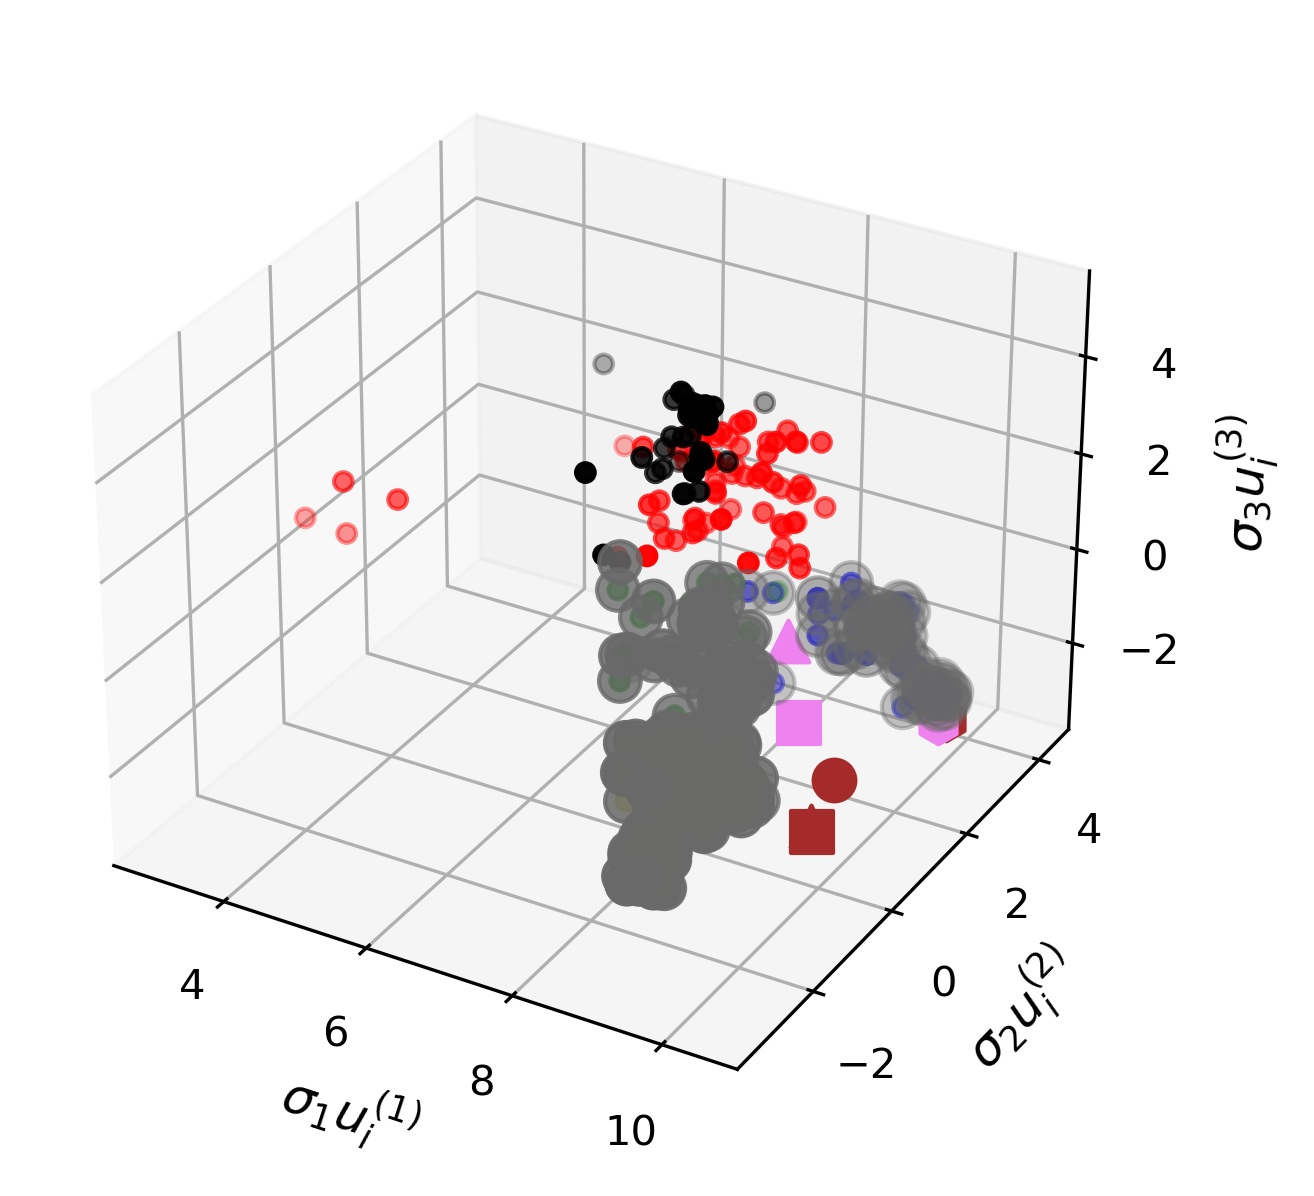

In [36]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

ax.scatter(Anc1_extant_usig1, Anc1_extant_usig2, 
           Anc1_extant_usig3, c='dimgray', s=100)

#ax.scatter(consensus_usig_i[0], consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_Anc1_kmeans.pdf')

make_movies = False
if make_movies:
    imagedata = []
    for ii in range(0,360,1):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)
        data = imageio.imread('movie{}.png'.format(ii))
        imagedata.append(data)

    imageio.mimwrite('rnaseH_tree_seq_Anc1_kmeans.mp4', imagedata, format= '.mp4', fps = 20)

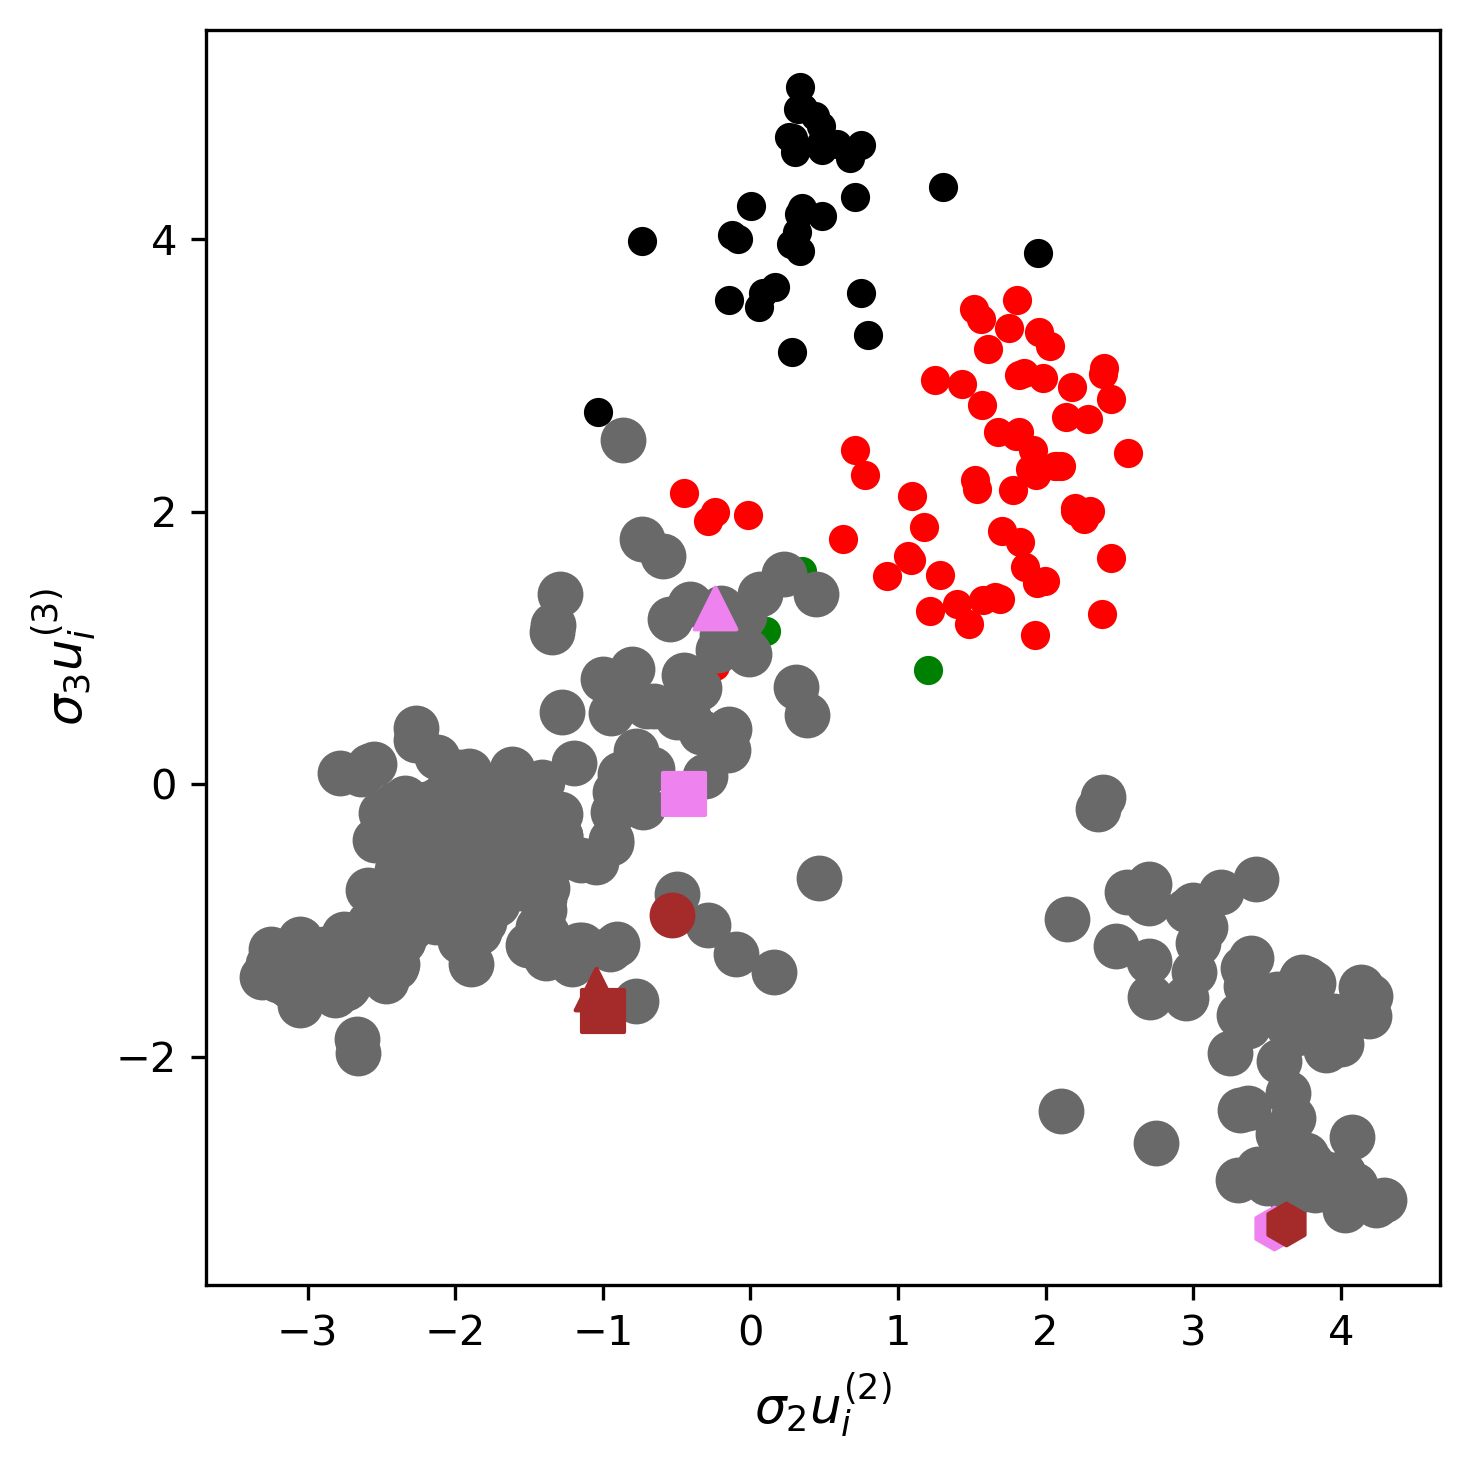

In [49]:
# 2d plot of Anc1

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(Anc1_extant_usig2, 
           Anc1_extant_usig3, c='dimgrey', s=100)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

#ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_kmeans_Anc1_2d.pdf')

## Anc2 descendant plot, along withMSA clusters, ancestors and consensus sequences.

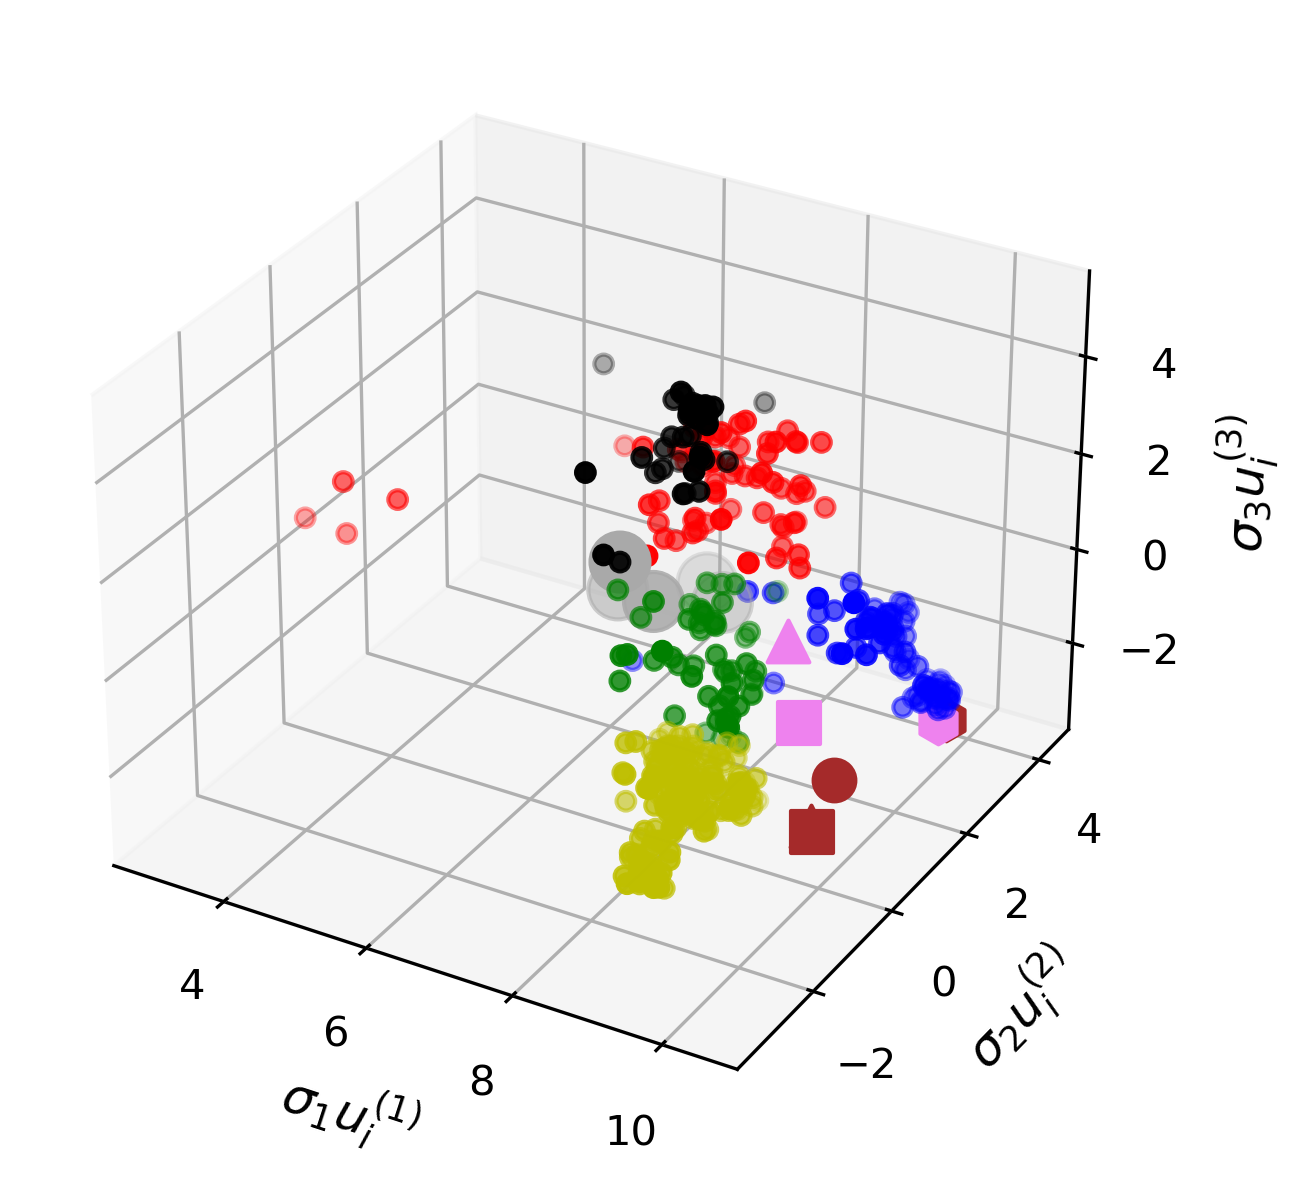

In [54]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

ax.scatter(Anc2_extant_usig1, Anc2_extant_usig2, 
           Anc2_extant_usig3, c='darkgray', s=200)

#ax.scatter(consensus_usig_i[0], consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_Anc2_kmeans.pdf')

make_movies = False
if make_movies:
    imagedata = []
    for ii in range(0,360,1):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)
        data = imageio.imread('movie{}.png'.format(ii))
        imagedata.append(data)

    imageio.mimwrite('rnaseH_tree_seq_Anc2_kmeans.mp4', imagedata, format= '.mp4', fps = 20)

## Anc3 descendant plot, along withMSA clusters, ancestors and consensus sequences.

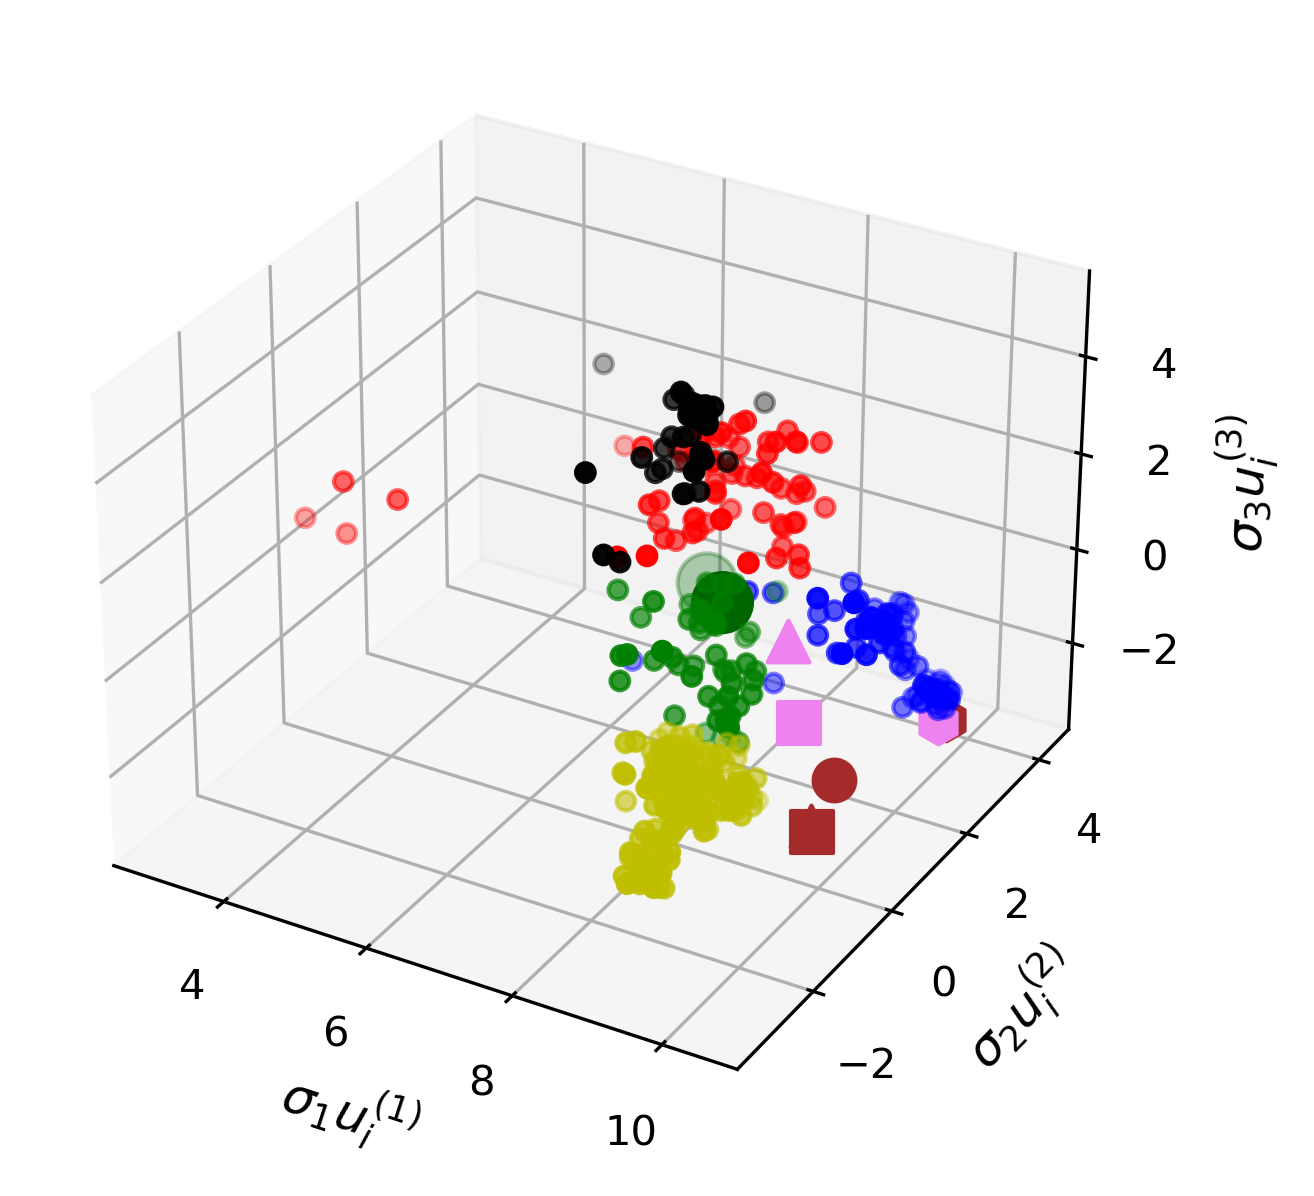

In [28]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

ax.scatter(Anc3_extant_usig1, Anc3_extant_usig2, 
           Anc3_extant_usig3, c='darkgreen', s=200)

#ax.scatter(consensus_usig_i[0], consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_Anc3_kmeans.pdf')

make_movies = False
if make_movies:
    imagedata = []
    for ii in range(0,360,1):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)
        data = imageio.imread('movie{}.png'.format(ii))
        imagedata.append(data)

    imageio.mimwrite('rnaseH_tree_seq_Anc3_kmeans.mp4', imagedata, format= '.mp4', fps = 20)

## Plot of descendant groups including subtractive groups, along withMSA clusters, ancestors and consensus sequences.

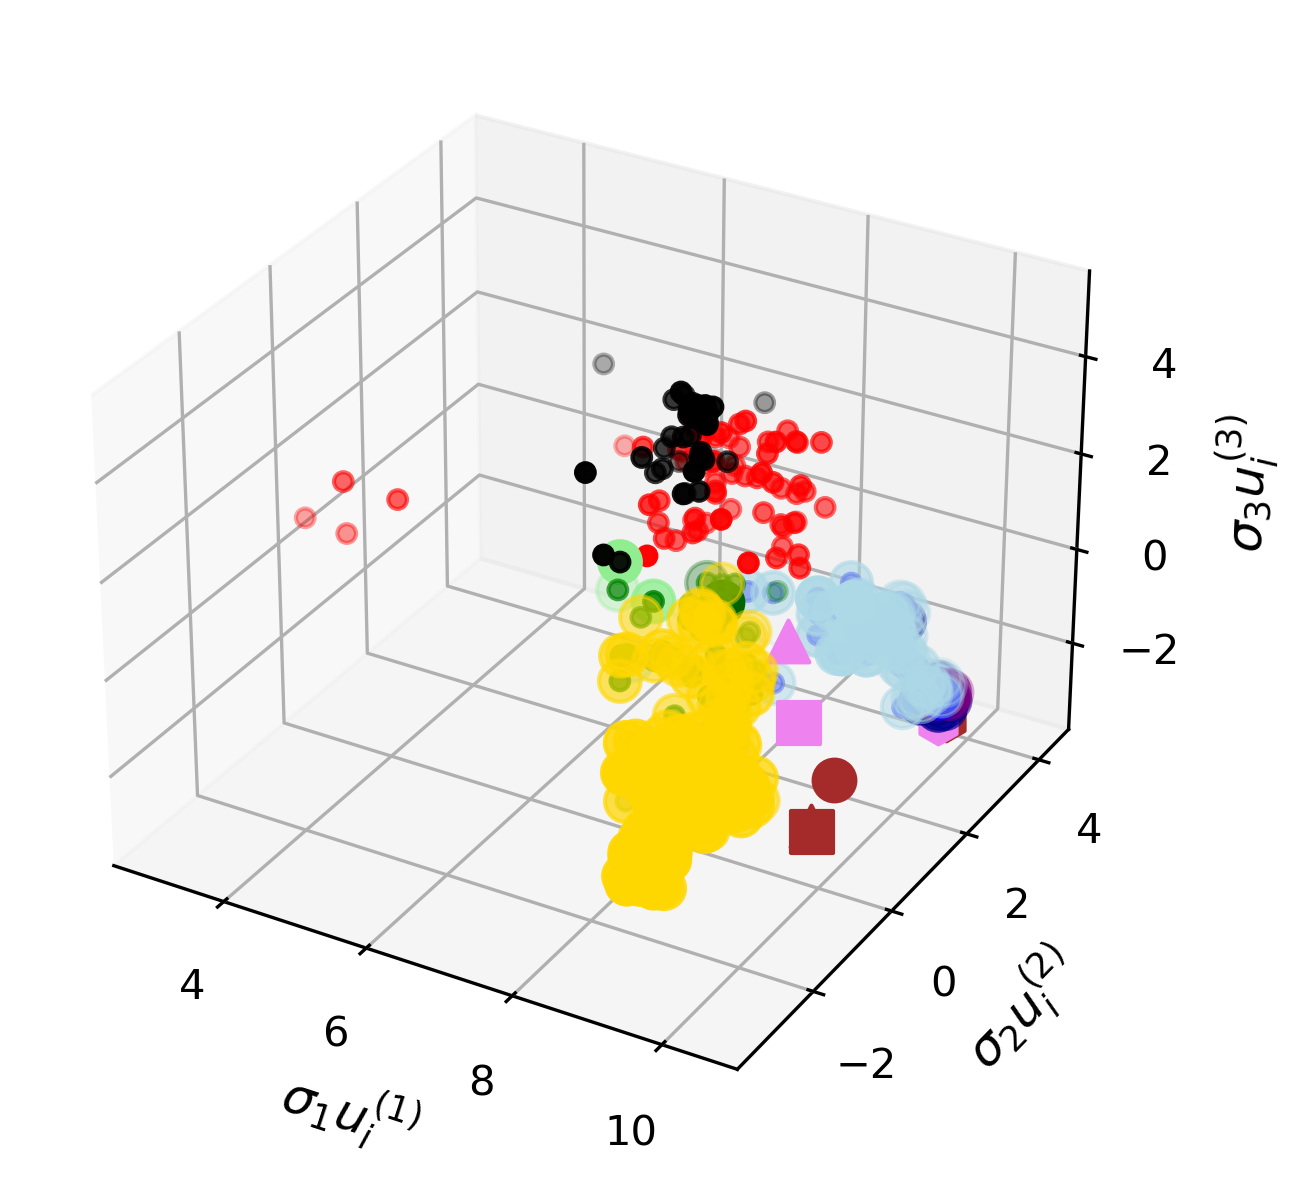

In [50]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][0], anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][0], anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][0], anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][0], anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][0], anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][0], anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][0], anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

ax.scatter(A_not_B_extant_usig1, A_not_B_extant_usig2, 
           A_not_B_extant_usig3, c='gold', s=100)
ax.scatter(B_not_C_extant_usig1, B_not_C_extant_usig2, 
           B_not_C_extant_usig3, c='lightblue', s=100)
ax.scatter(C_not_D_extant_usig1, C_not_D_extant_usig2, 
           C_not_D_extant_usig3, c='darkblue', s=100)
ax.scatter(AncD_extant_usig1, AncD_extant_usig2, 
           AncD_extant_usig3, c='purple', s=100)
ax.scatter(two_not_three_extant_usig1, two_not_three_extant_usig2, 
           two_not_three_extant_usig3, c='lightgreen', s=100)
ax.scatter(Anc3_extant_usig1, Anc3_extant_usig2, 
           Anc3_extant_usig3, c='darkgreen', s=100)


#ax.scatter(consensus_usig_i[0], consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_descendants_kmeans.pdf')

make_movies = False
if make_movies:
    imagedata = []
    for ii in range(0,360,1):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)
        data = imageio.imread('movie{}.png'.format(ii))
        imagedata.append(data)

    imageio.mimwrite('rnaseH_tree_seq_Anc3_kmeans.mp4', imagedata, format= '.mp4', fps = 20)

## 2D plots of $\sigma_2 u_i^{(2)}$ versus $\sigma_3 u_i^{(3)}$ for clusters

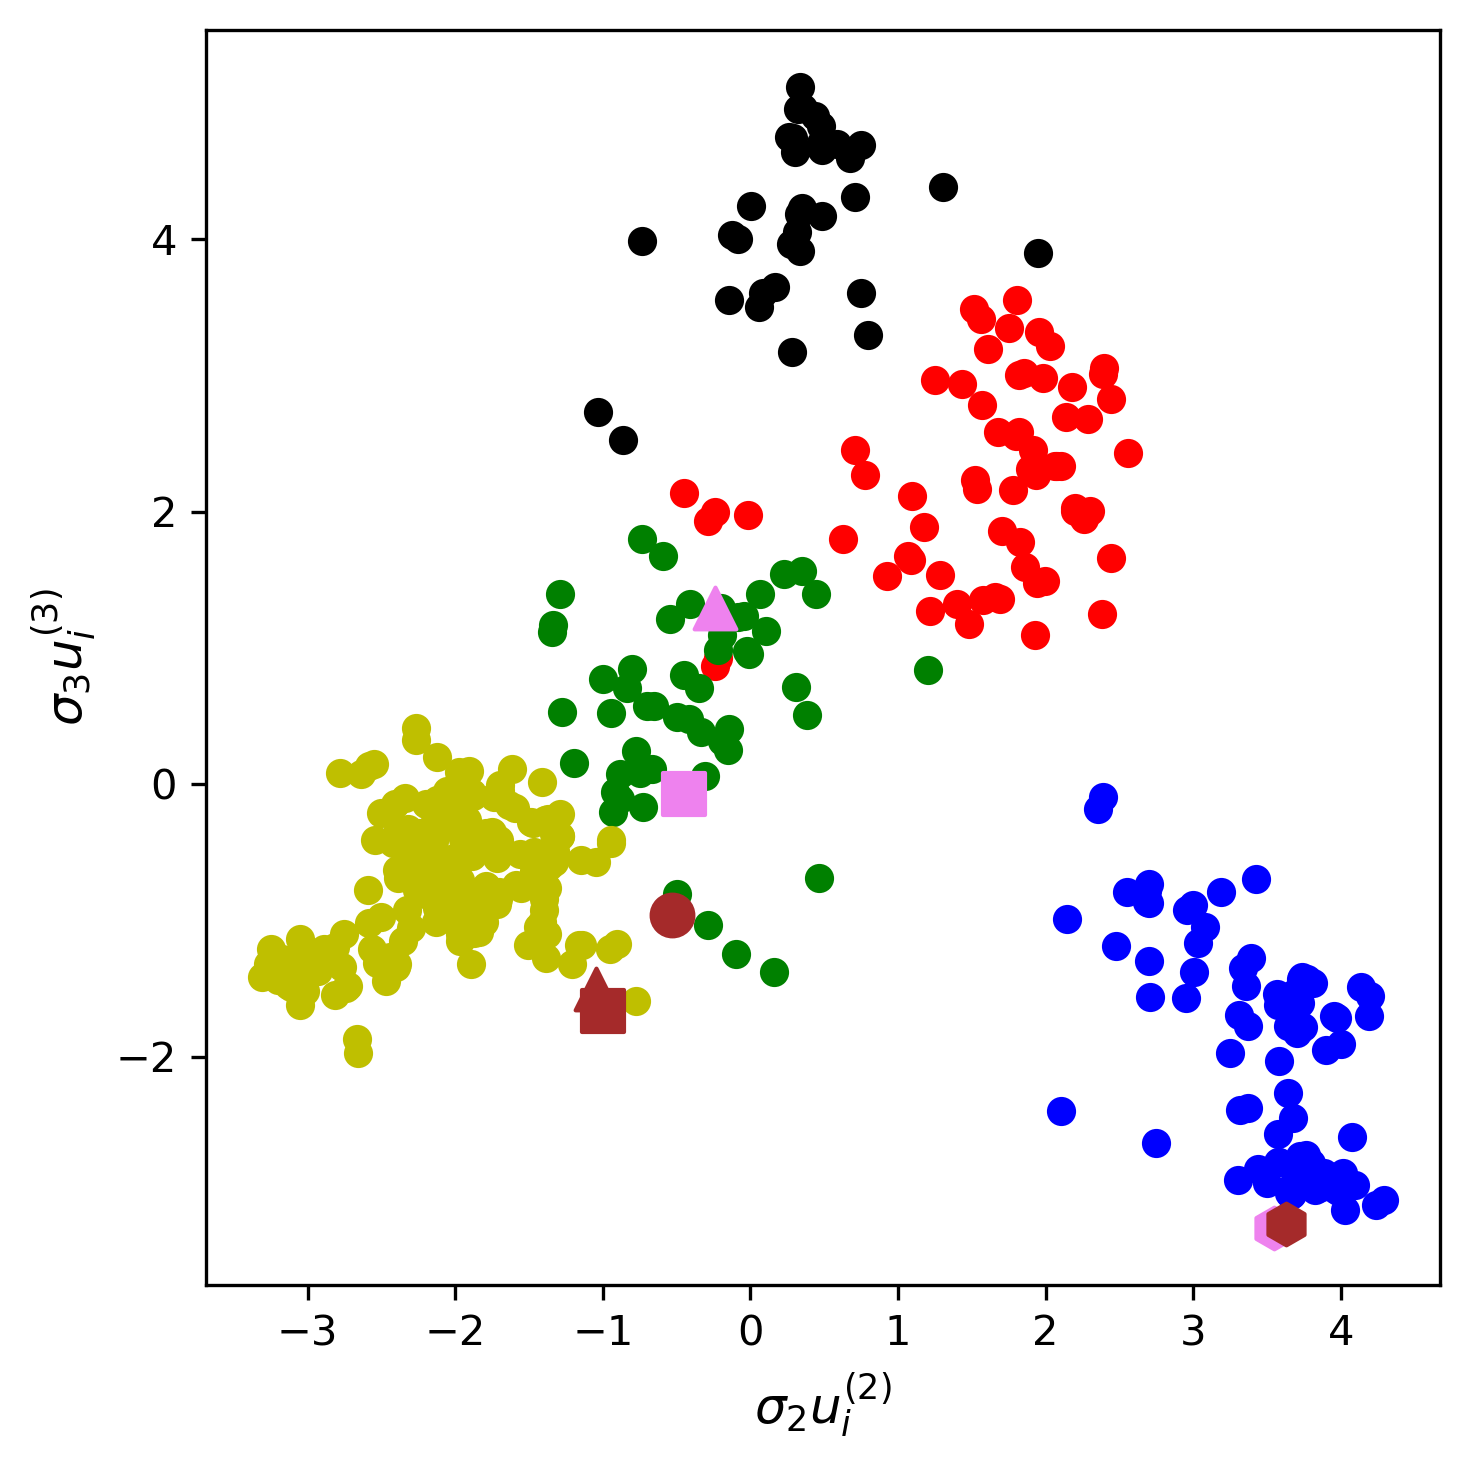

In [45]:
fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

#ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_kmeans_2d.pdf')

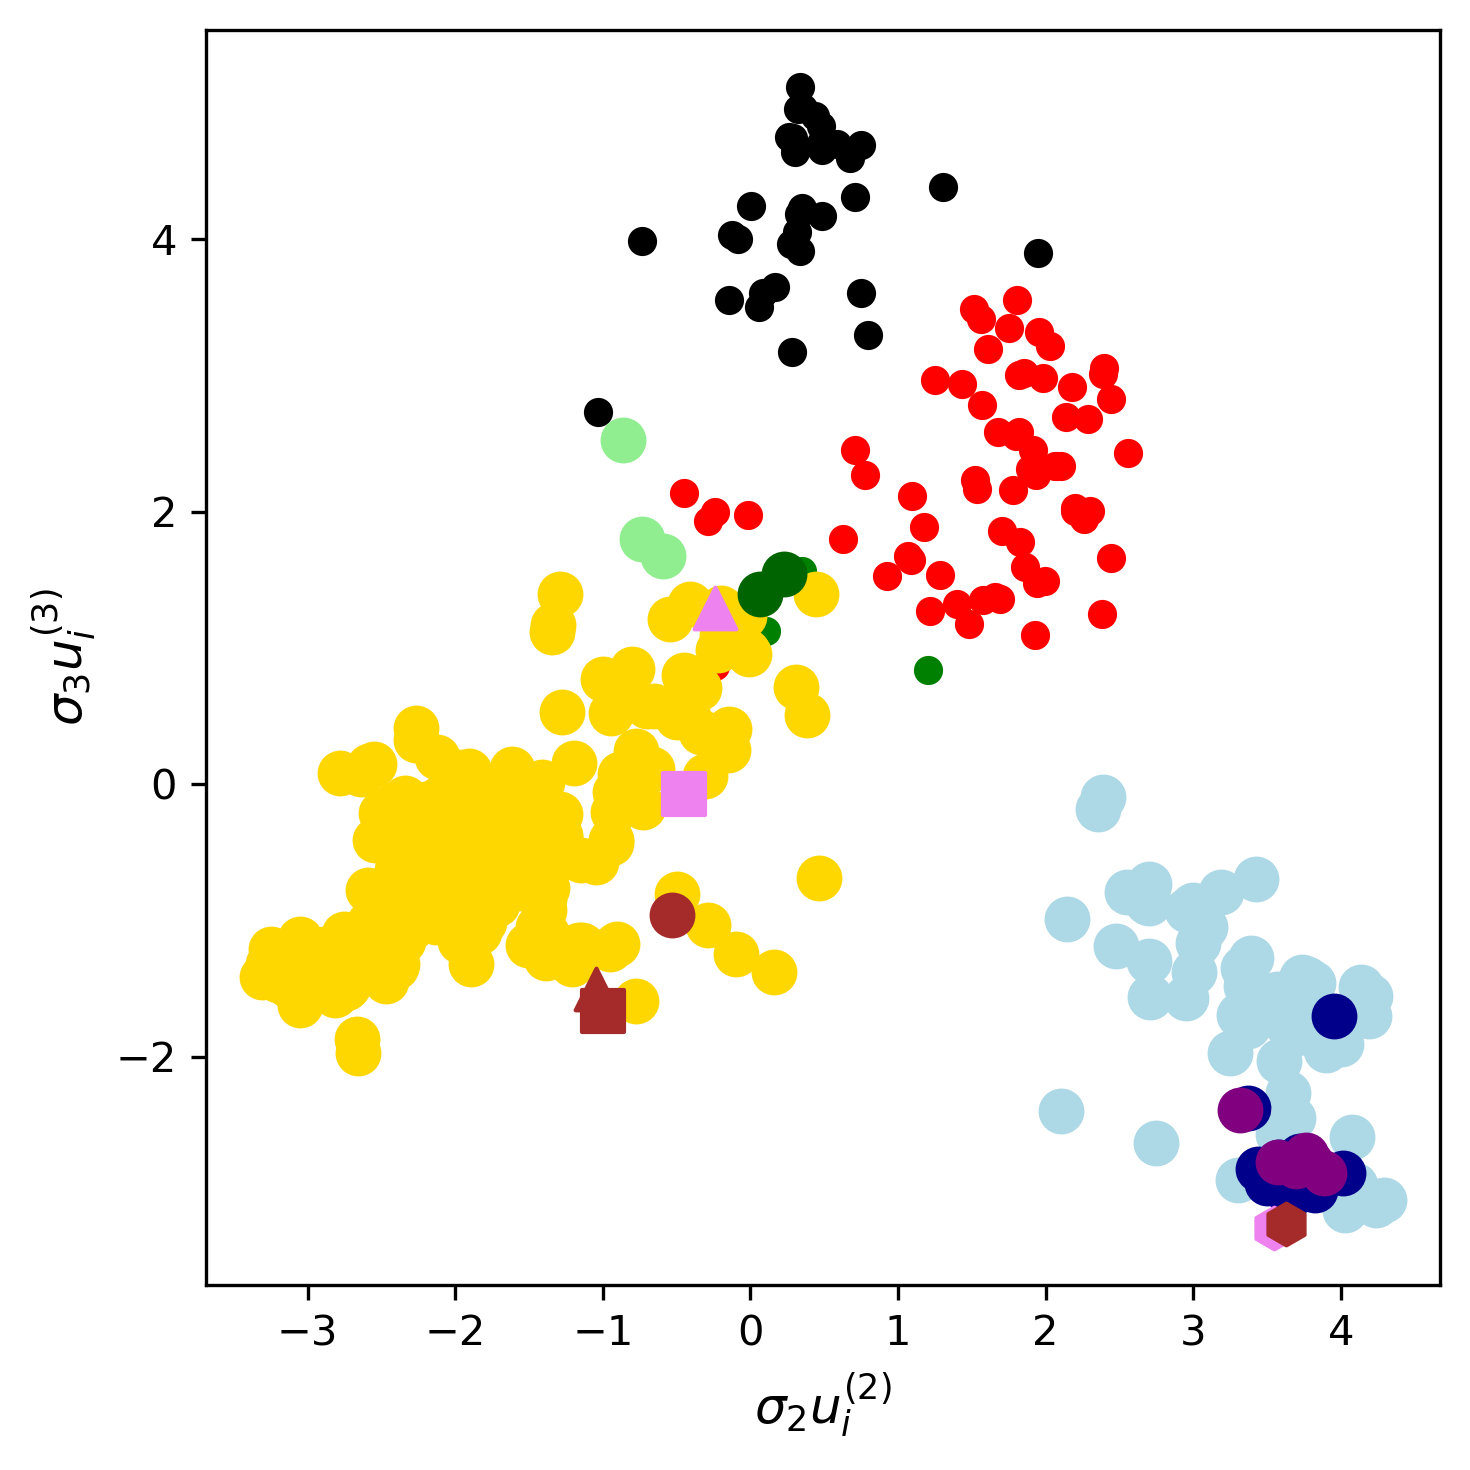

In [51]:
# Descendant 2d plot

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(A_not_B_extant_usig2, 
           A_not_B_extant_usig3, c='gold', s=100)
ax.scatter(B_not_C_extant_usig2, 
           B_not_C_extant_usig3, c='lightblue', s=100)
ax.scatter(C_not_D_extant_usig2, 
           C_not_D_extant_usig3, c='darkblue', s=100)
ax.scatter(AncD_extant_usig2, 
           AncD_extant_usig3, c='purple', s=100)
ax.scatter(two_not_three_extant_usig2, 
           two_not_three_extant_usig3, c='lightgreen', s=100)
ax.scatter(Anc3_extant_usig2, 
           Anc3_extant_usig3, c='darkgreen', s=100)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='violet', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='violet', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='violet', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='brown', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='brown', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='brown', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='brown', s=100, marker='h')

#ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_descendants_kmeans_2d.pdf')

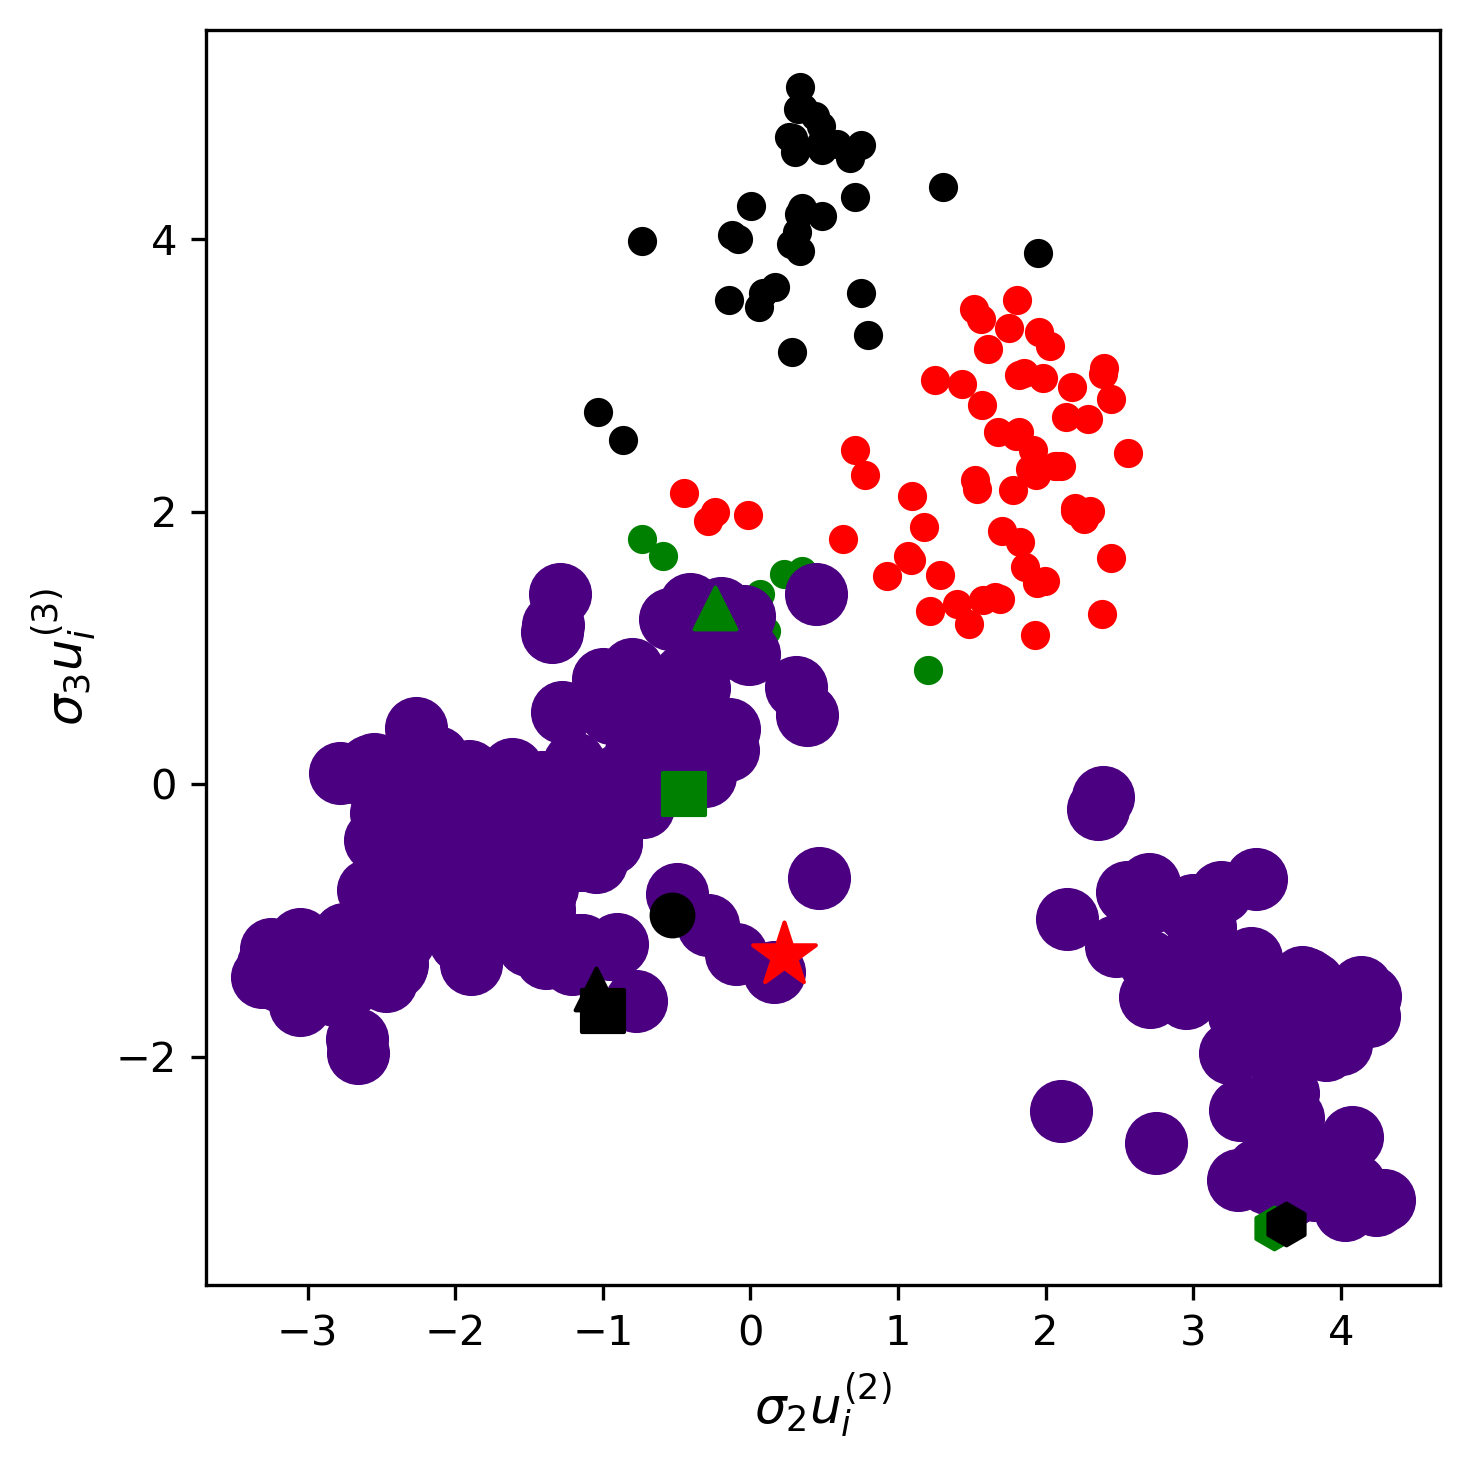

In [53]:
# AncA 2d plot

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(AncA_extant_usig2, 
           AncA_extant_usig3, c='indigo', s=200)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='g', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='g', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='g', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='k', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='k', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='k', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='k', s=100, marker='h')

ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_AncA_kmeans_2d.pdf')

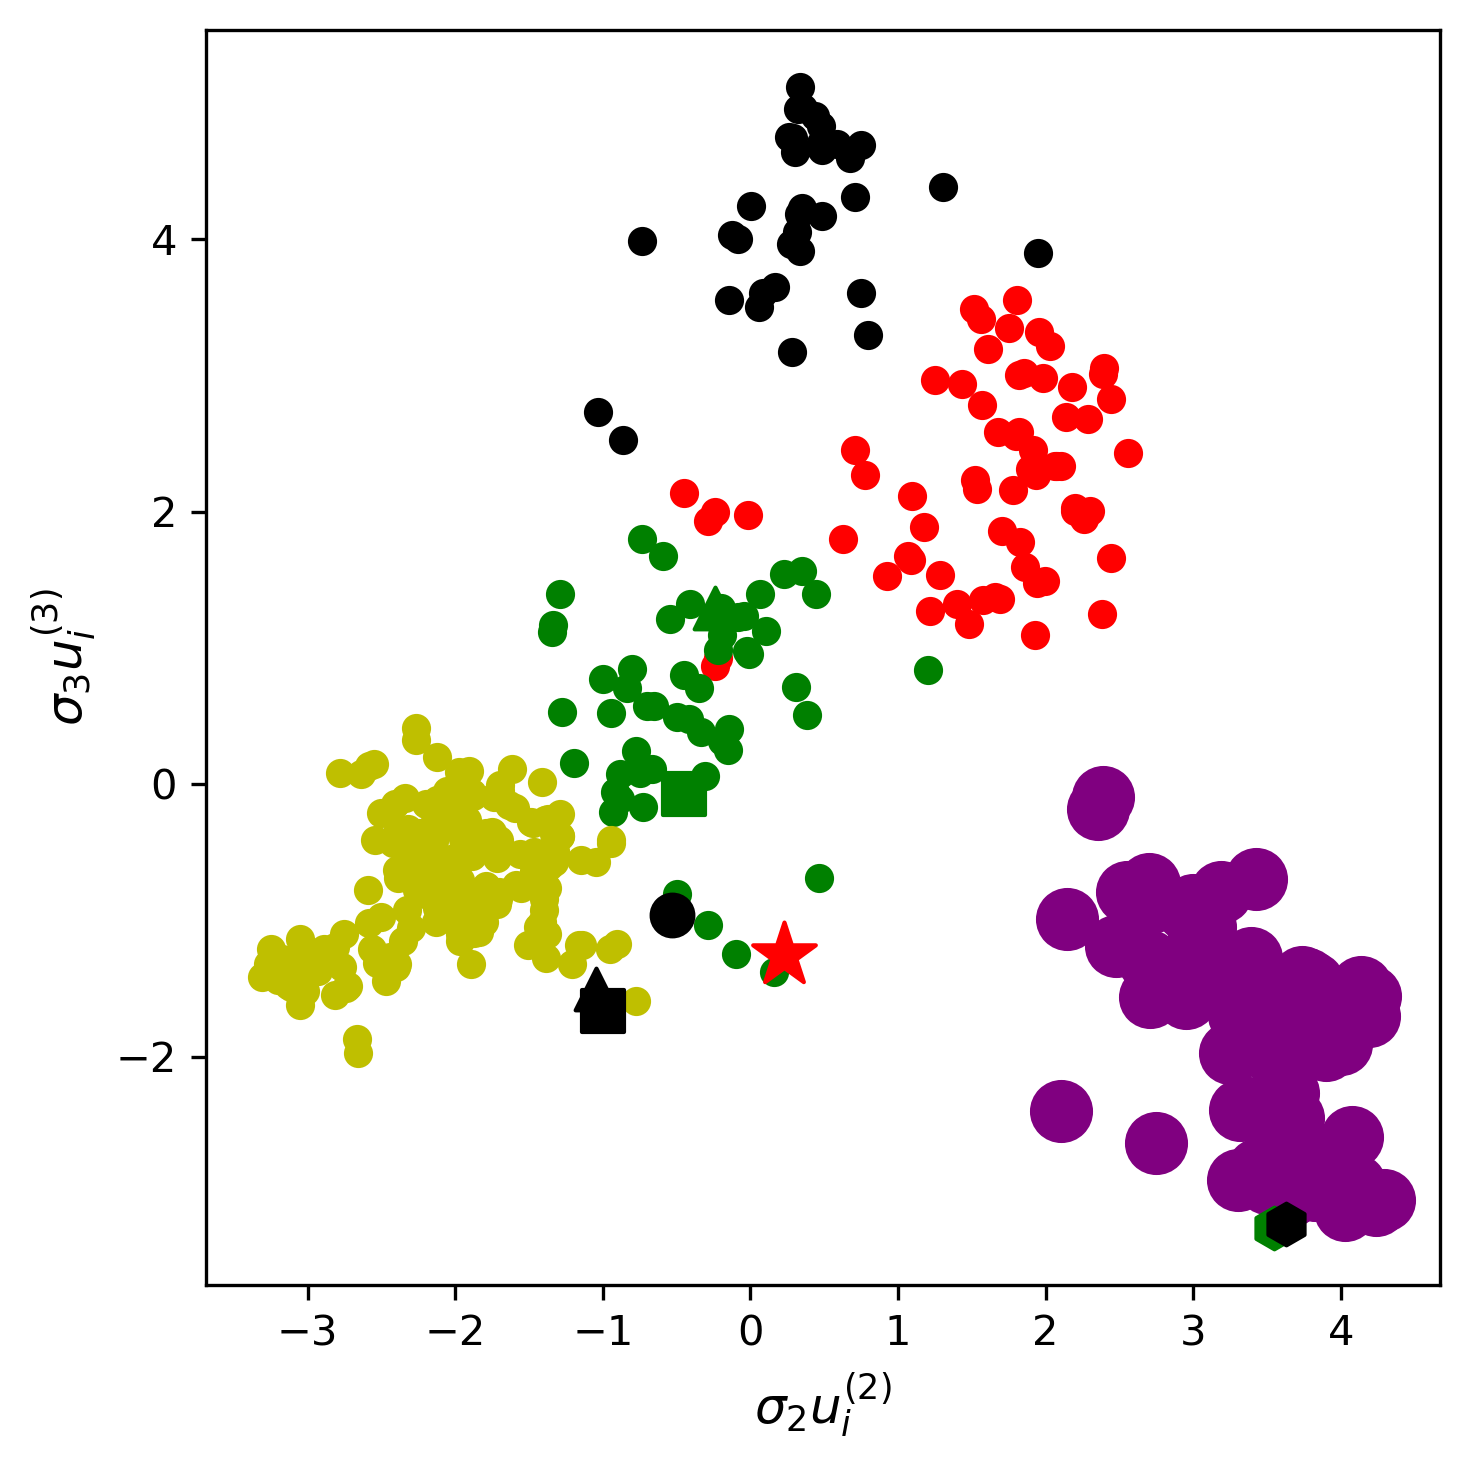

In [50]:
# AncB 2d plot

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(AncB_extant_usig2, 
           AncB_extant_usig3, c='purple', s=200)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='g', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='g', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='g', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='k', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='k', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='k', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='k', s=100, marker='h')

ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_AncB_kmeans_2d.pdf')

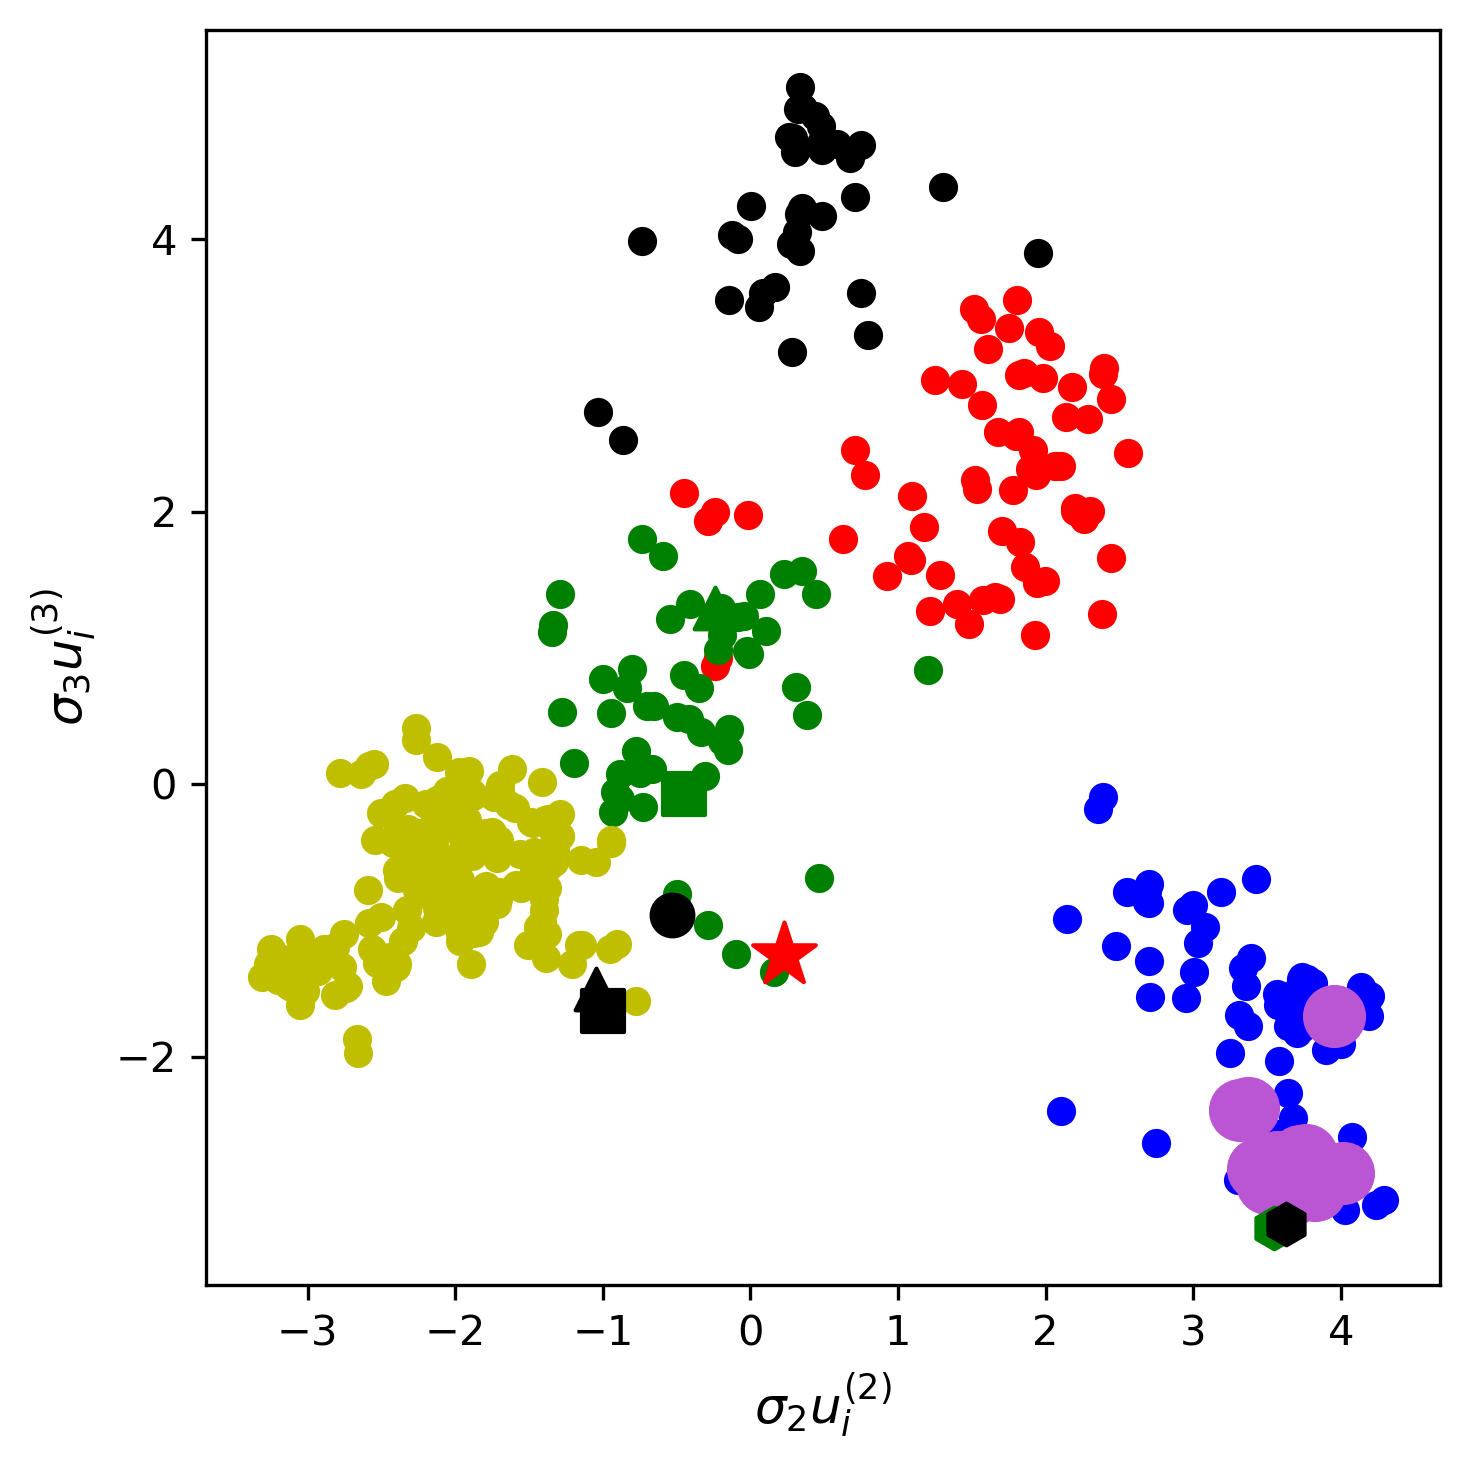

In [52]:
# AncC 2d plot

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(AncC_extant_usig2, 
           AncC_extant_usig3, c='mediumorchid', s=200)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='g', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='g', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='g', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='k', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='k', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='k', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='k', s=100, marker='h')

ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_AncC_kmeans_2d.pdf')


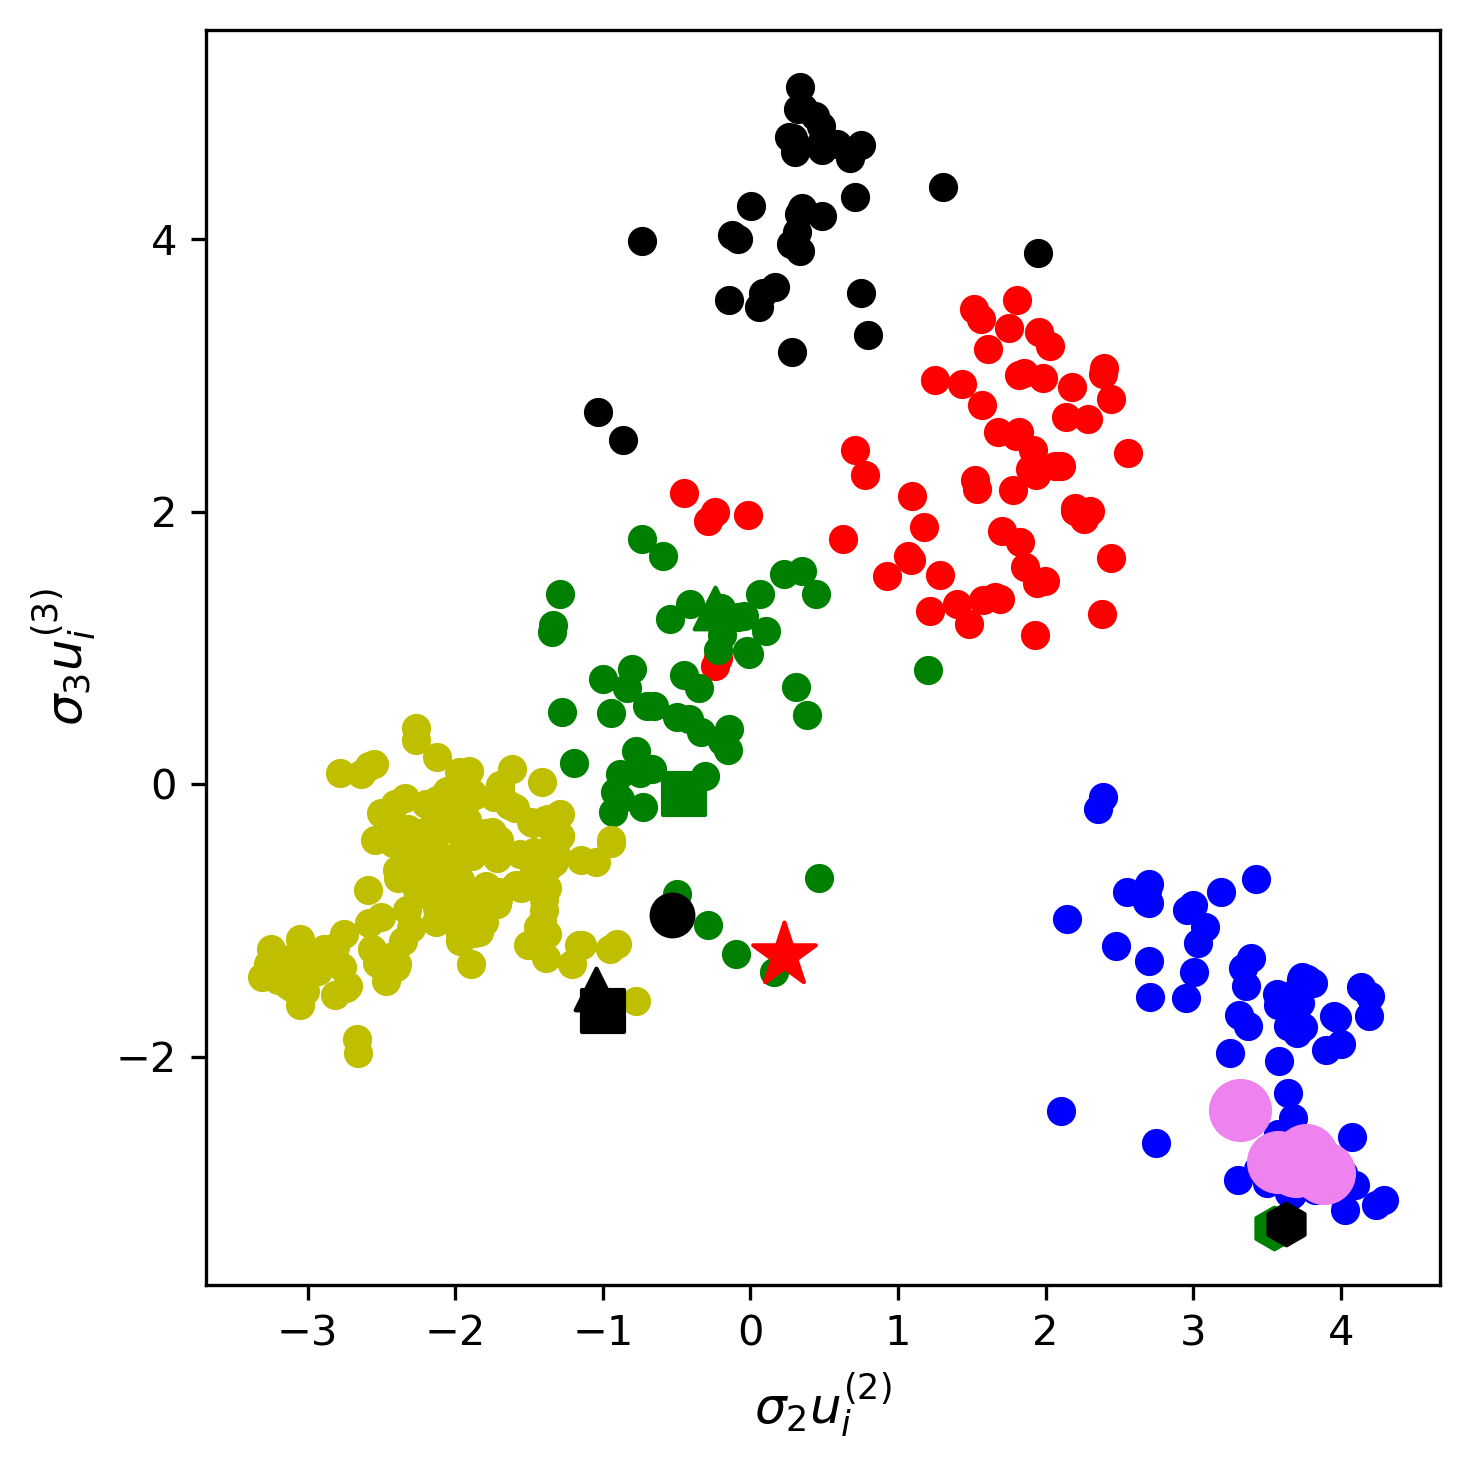

In [54]:
# AncD 2d plot

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(AncD_extant_usig2, 
           AncD_extant_usig3, c='violet', s=200)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='g', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='g', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='g', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='k', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='k', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='k', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='k', s=100, marker='h')

ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_AncD_kmeans_2d.pdf')


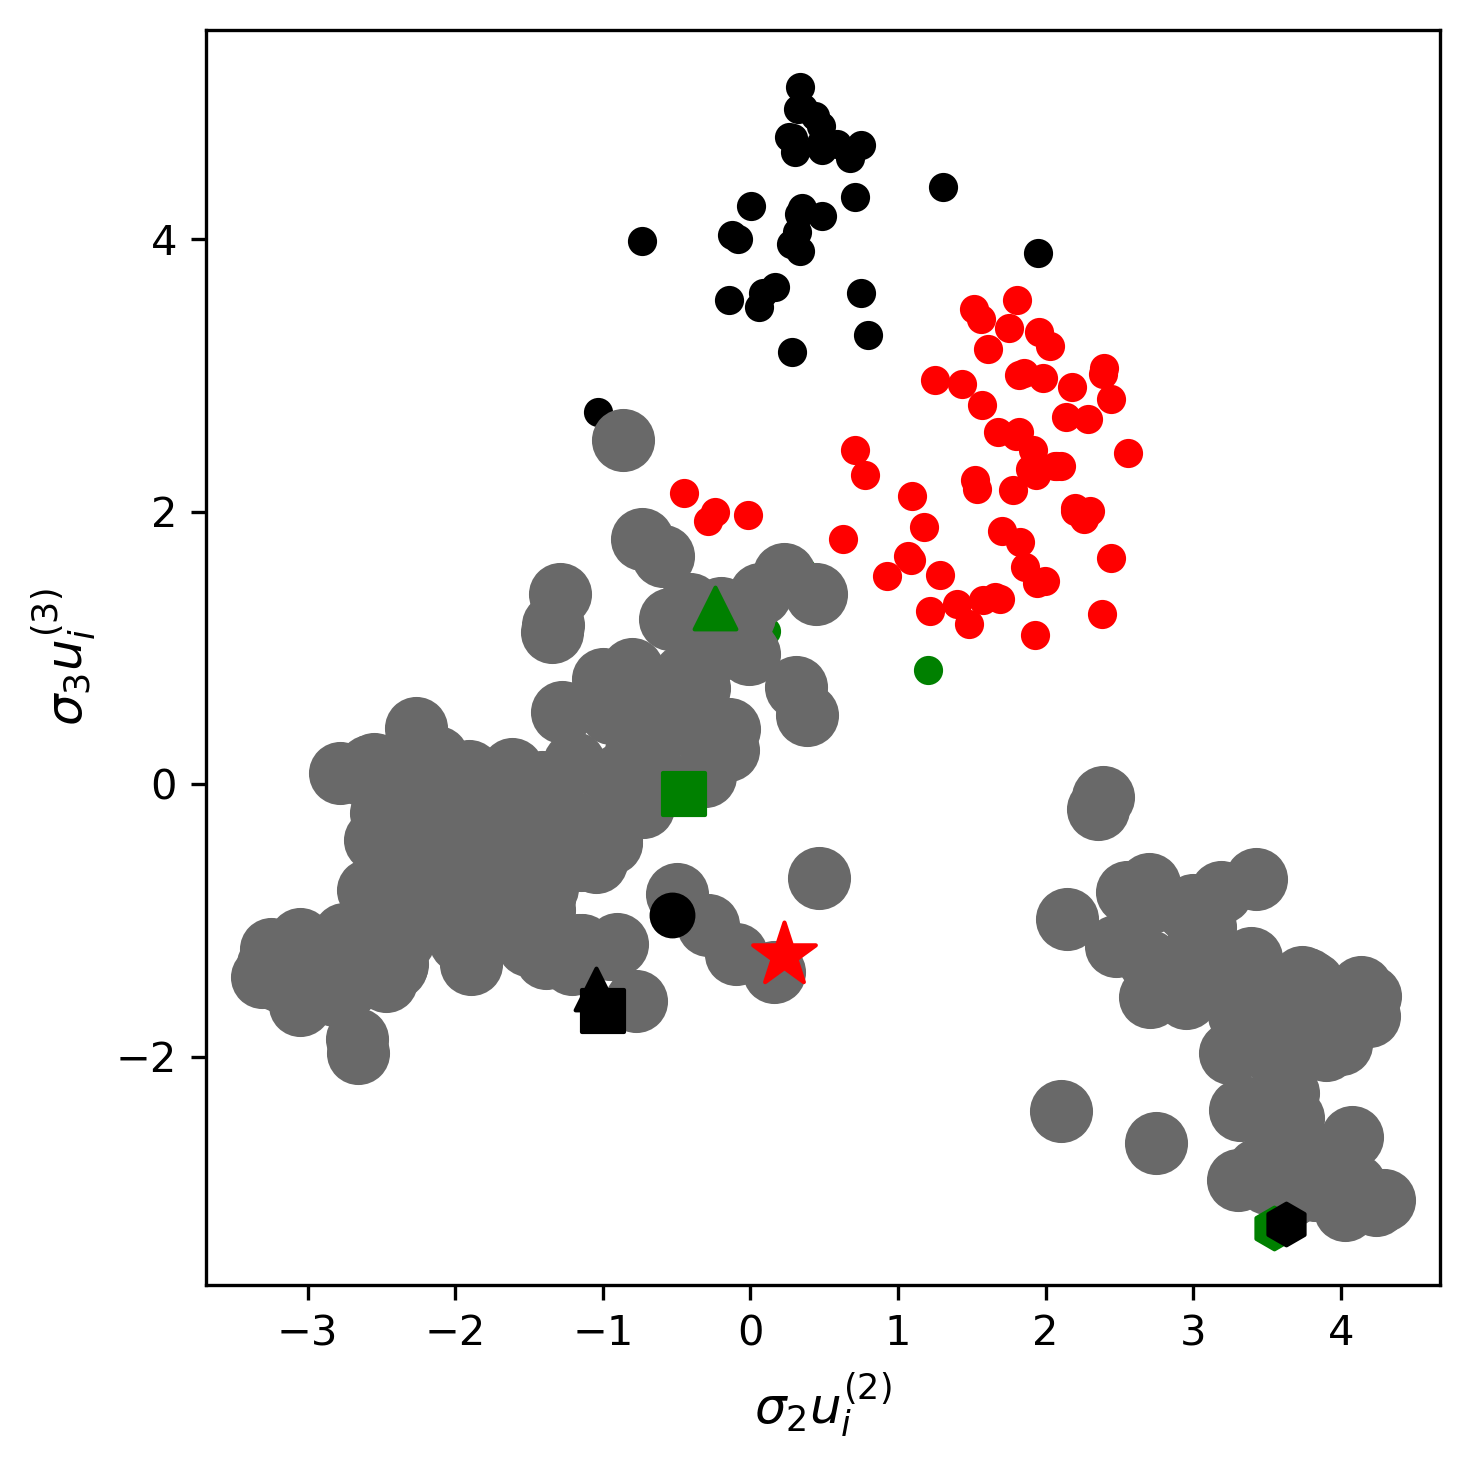

In [55]:
# Anc1 2d plot

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(Anc1_extant_usig2, 
           Anc1_extant_usig3, c='dimgray', s=200)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='g', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='g', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='g', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='k', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='k', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='k', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='k', s=100, marker='h')

ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_Anc1_kmeans_2d.pdf')


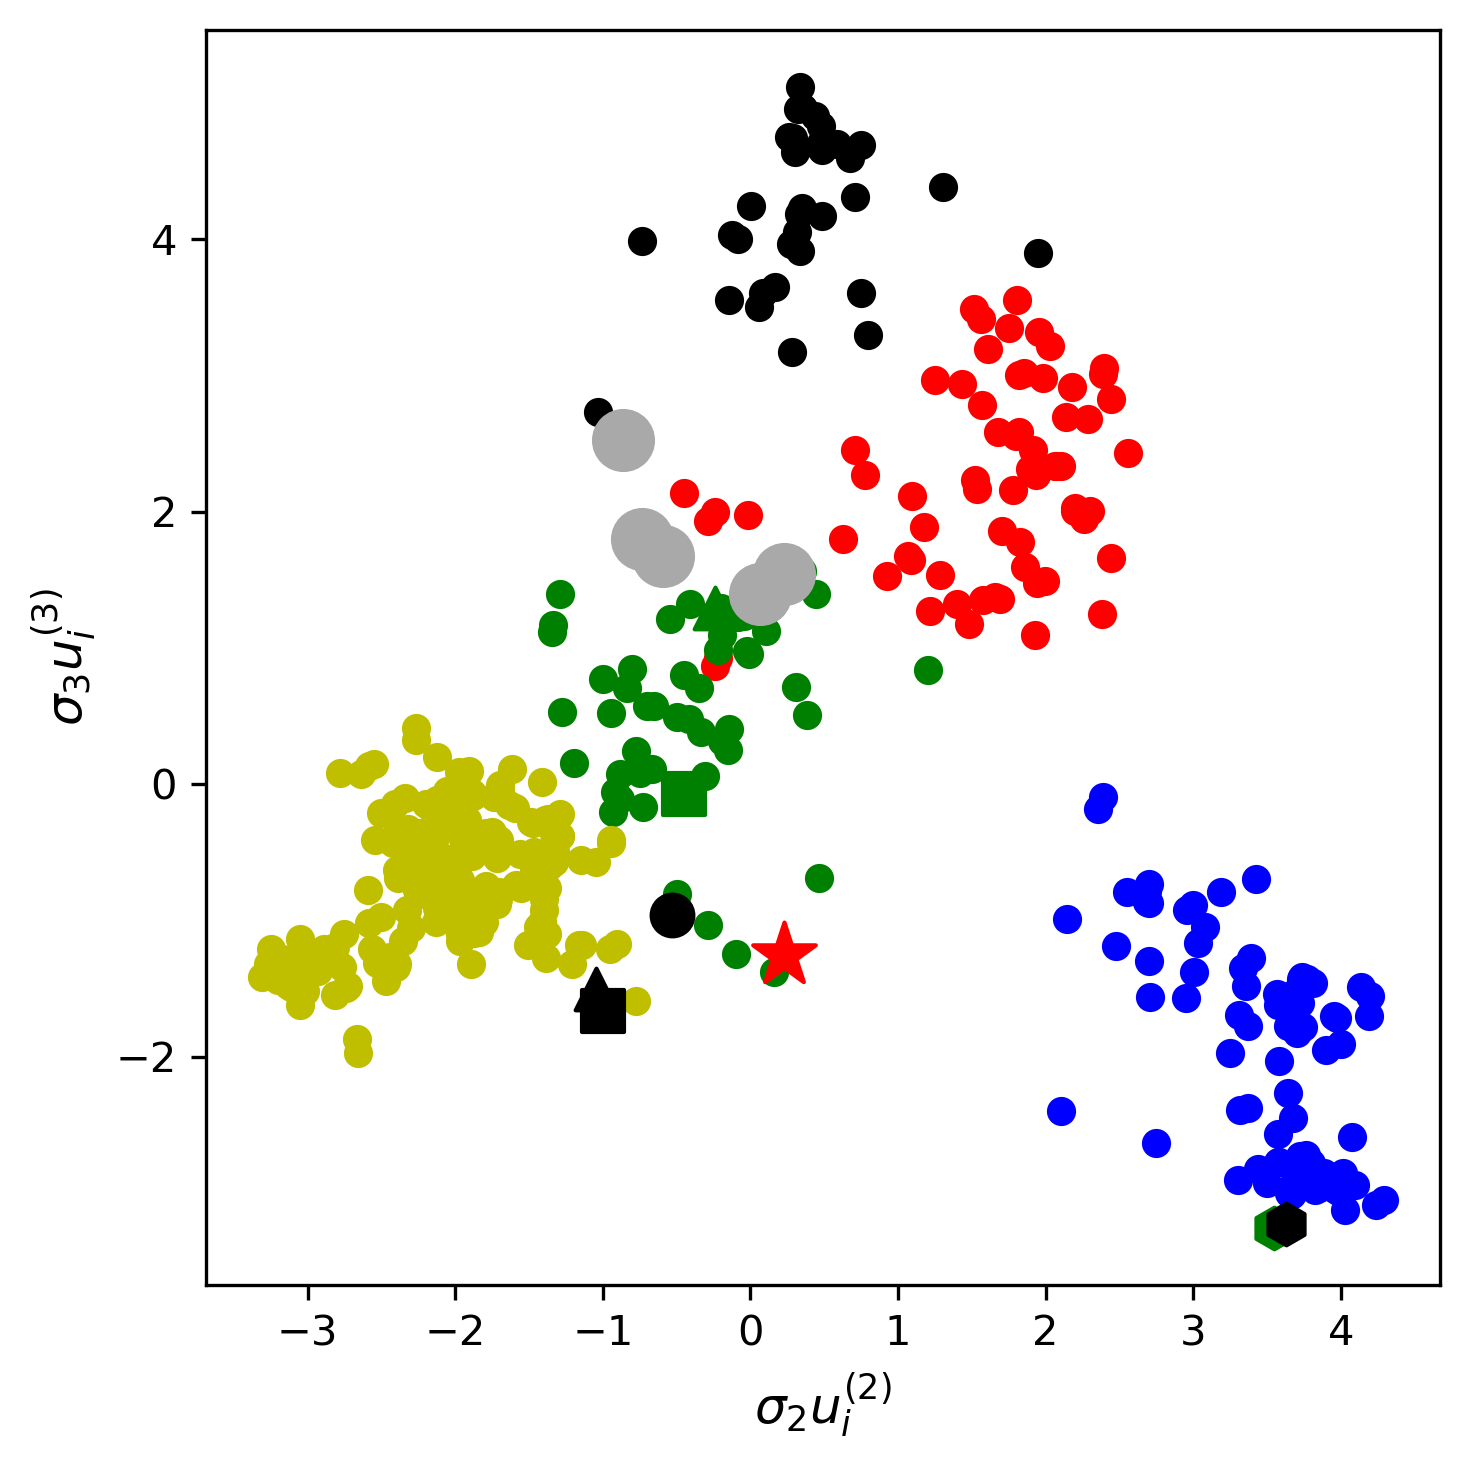

In [56]:
# Anc2 2d plot

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(Anc2_extant_usig2, 
           Anc2_extant_usig3, c='darkgray', s=200)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='g', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='g', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='g', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='k', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='k', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='k', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='k', s=100, marker='h')

ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_Anc2_kmeans_2d.pdf')


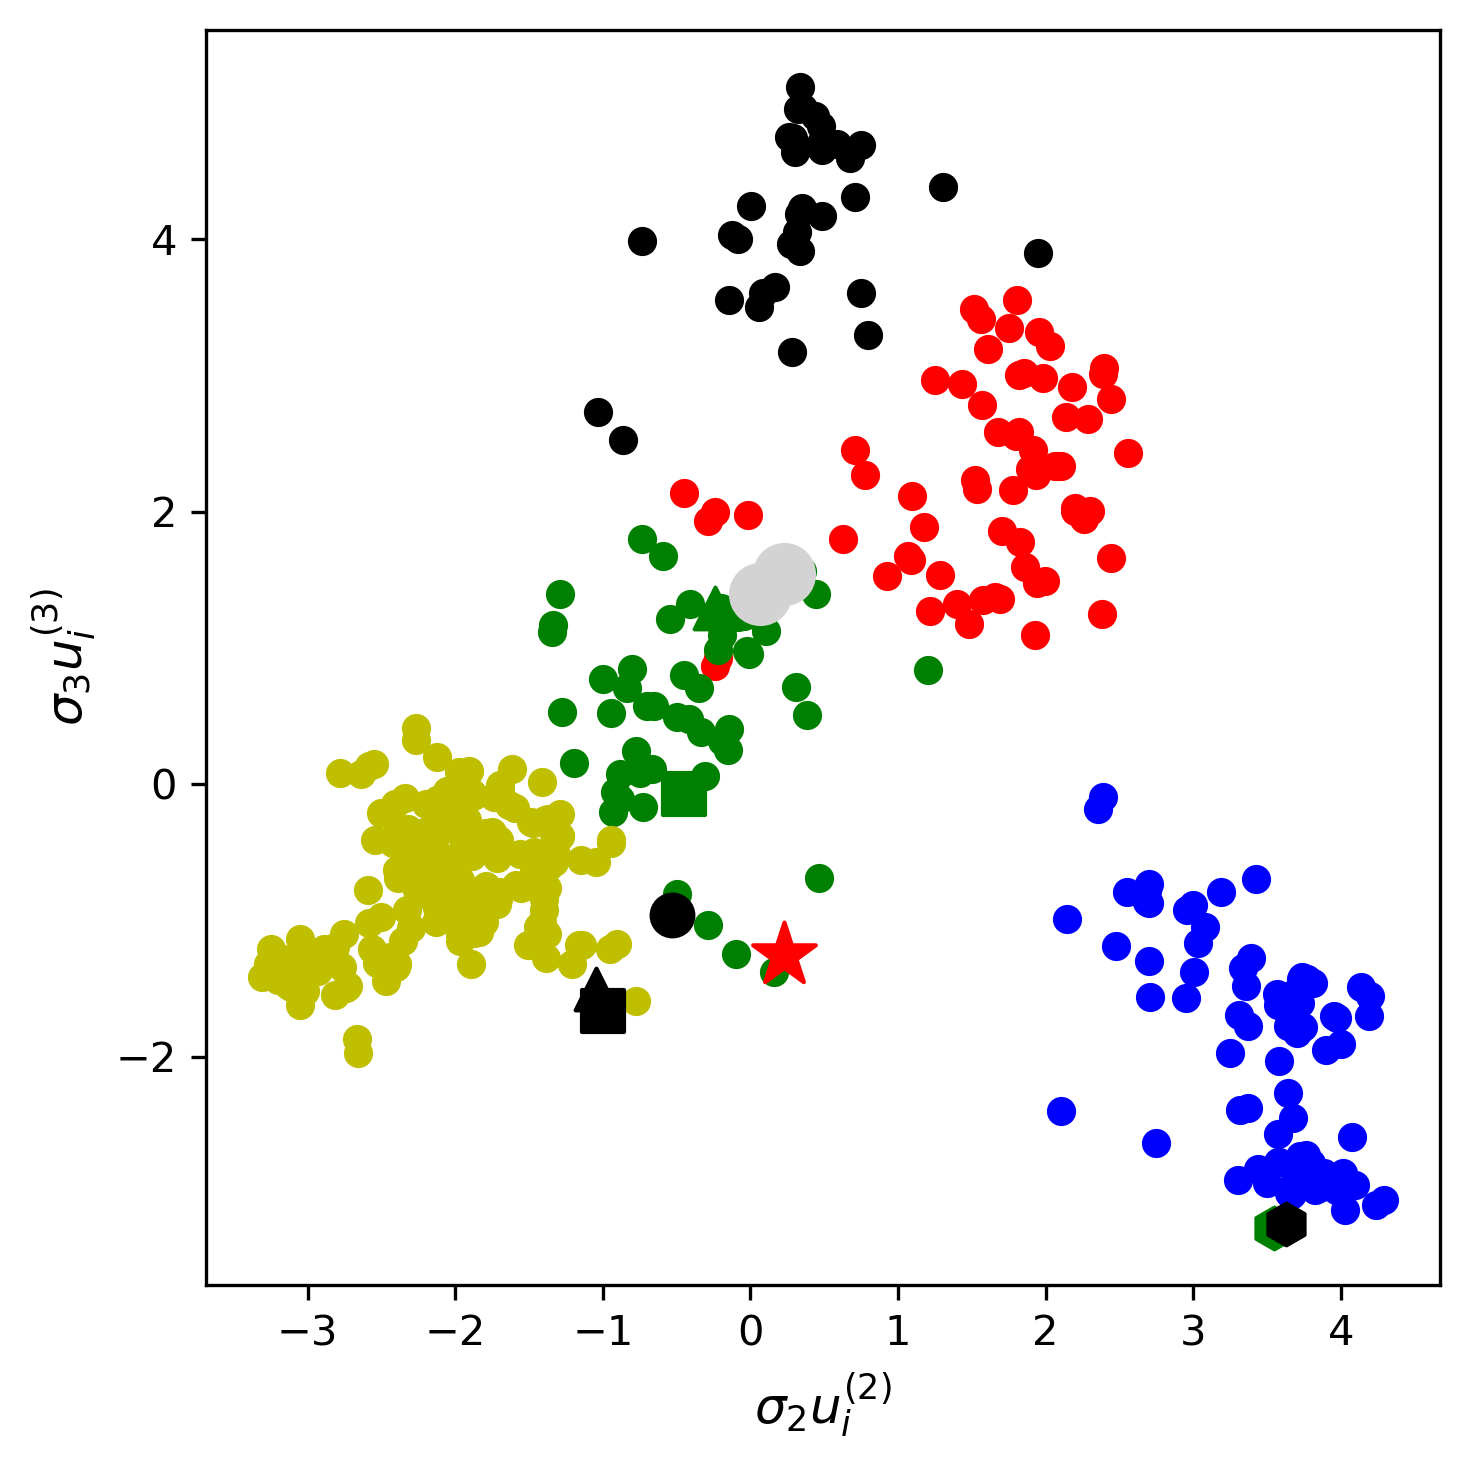

In [57]:
# Anc3 2d plot

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

ax.scatter(Anc3_extant_usig2, 
           Anc3_extant_usig3, c='lightgray', s=200)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='g', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='g', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='g', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='k', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='k', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='k', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='k', s=100, marker='h')

ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_Anc3_kmeans_2d.pdf')

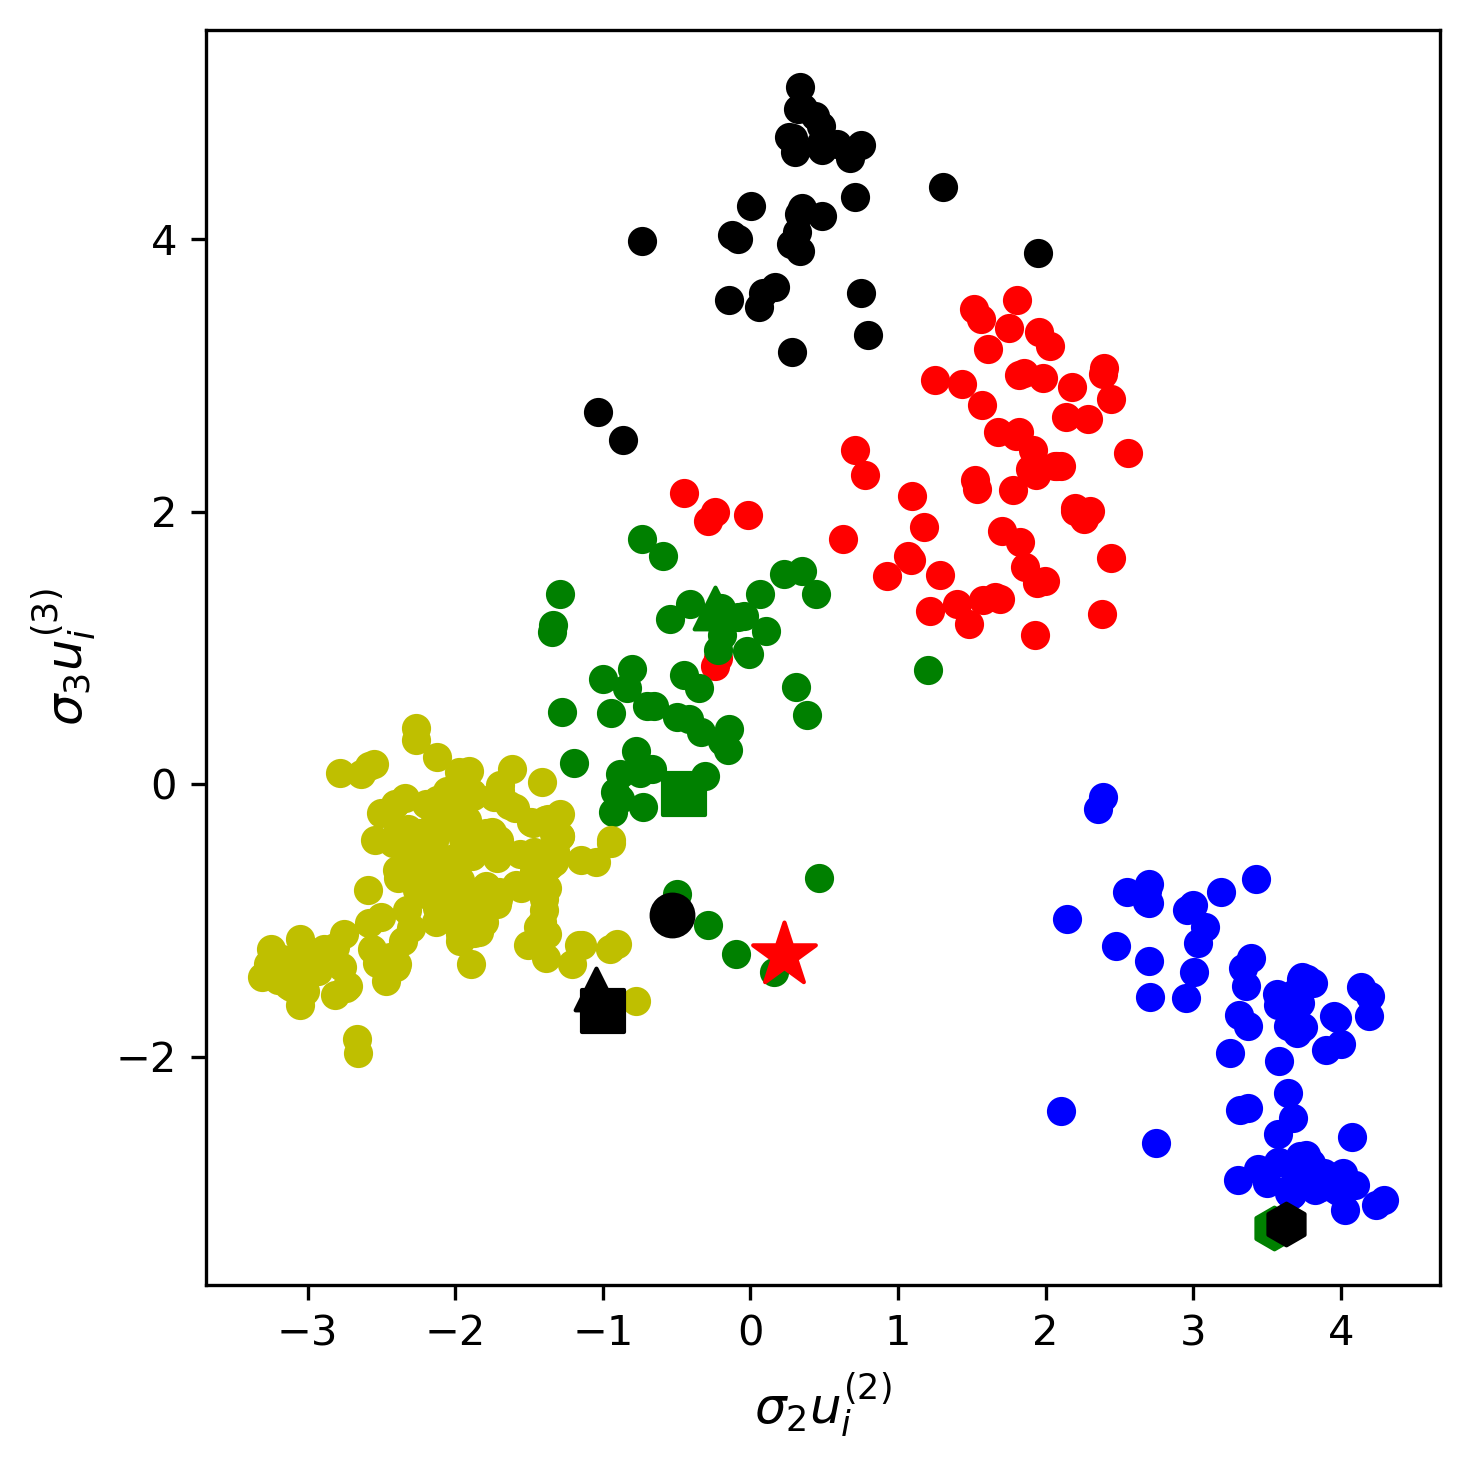

In [58]:
# 2d plot no descendants

fig = plt.figure(dpi=300, figsize=(5,5))
ax = fig.add_subplot()

ax.scatter(kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r')

ax.scatter(kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g')

ax.scatter(kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b')

ax.scatter(kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y')

ax.scatter(kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
           kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k')

#ax.scatter(Anc3_extant_usig2, 
#           Anc3_extant_usig3, c='lightgray', s=200)

ax.scatter(anc_cons_usig_i_dict['>Anc1*'][1], 
           anc_cons_usig_i_dict['>Anc1*'][2], c='g', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncA*'][1], 
           anc_cons_usig_i_dict['>AncA*'][2], c='g', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncC*'][1], 
           anc_cons_usig_i_dict['>AncC*'][2], c='g', s=100, marker='h')

ax.scatter(anc_cons_usig_i_dict['>WholeCons*'][1], 
           anc_cons_usig_i_dict['>WholeCons*'][2], c='k', s=100, marker='o')
ax.scatter(anc_cons_usig_i_dict['>Anc1Cons*'][1], 
           anc_cons_usig_i_dict['>Anc1Cons*'][2], c='k', s=100, marker='^')
ax.scatter(anc_cons_usig_i_dict['>AncACons*'][1], 
           anc_cons_usig_i_dict['>AncACons*'][2], c='k', s=100, marker='s')
ax.scatter(anc_cons_usig_i_dict['>AncCCons*'][1], 
           anc_cons_usig_i_dict['>AncCCons*'][2], c='k', s=100, marker='h')

ax.scatter(consensus_usig_i[1], consensus_usig_i[2], c='r', s=250, marker='*')

ax.set_xlabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

plt.tight_layout()
plt.savefig('rnaseH_tree_seq_kmeans_2d.pdf')

In [ ]:
F_cluster_dict = {}

for cluster in range(k):
    F_cluster_dict[f'F_cluster_{cluster}'] = np.array([])
    F_cluster_dict[f'F_cluster_{cluster}_sum'] = np.zeros(len(F[0]))
    cluster_count = 0

    for seq_number in range(len(F)):
        if y_pred[seq_number] == cluster:
            F_cluster_dict[f'F_cluster_{cluster}_sum'] += F[seq_number]
            F_cluster_dict[f'F_cluster_{cluster}']\
                = np.append(F_cluster_dict[f'F_cluster_{cluster}'], F[seq_number])
            cluster_count += 1
    
    F_cluster_dict[f'F_cluster_{cluster}']\
       = F_cluster_dict[f'F_cluster_{cluster}'].reshape(cluster_count, len(F[seq_number]))  

In [47]:
len(Anc1_seqs_not_aligned)

303

In [48]:
len(AncA_seqs_not_aligned)

298

## 15. Plot cluster-filtered ($v^{(1)}$, $v^{(2)}$, $v^{(3)}$) triples.

In [ ]:
'''
Note this code was working but somehow I broke it.  Now it seems to run forever without
generating a plot.  Not a big deal due to the issue below, which is resolved in the 
following cell.
'''
cluster = 0

n_k0 = len(F_cluster_dict[f'F_cluster_{cluster}'])
ohe_length = len(F_cluster_dict[f'F_cluster_{cluster}'][0])

fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')
for residue in range(ohe_length):
    ax.scatter(FV1_cluster_dict[f'FV1_cluster_{cluster}'][seq],
                   FV2_cluster_dict[f'FV2_cluster_{cluster}'][seq],
                   FV3_cluster_dict[f'FV3_cluster_{cluster}'][seq], c='g', s=1)
ax.set_xlabel(f"$s_{{i,k}} v_k^{{(1)}}$", fontsize=12)
ax.set_ylabel(f"$s_{{i,k}} v_k^{{(2)}}$", fontsize=12)
ax.set_zlabel(f"$s_{{i,k}} v_k^{{(3)}}$", fontsize=12)

plt.tight_layout()

The problem with the plot above (aside from the fact that it is currently broken) is that there is no way to distinguish points that derive from every sequence in the cluster (i.e., that correspond to a residue that is 100 percent conserved) and residues in one sequence (or zero sequences, though these should show up at coordinate (0, 0, 0).  So below I will **scale each point by the number of sequences in the cluster that have that point**, using the "markersize=" command.  This will require me to loop through each point, which might take a long time.  No, now that I think about it, if I make a vector of ones that is ohe_length, and multiply it by $v^{(i)}$, and then scale those points by the number of sequences with that residue, I should get the same result.  And come to think of it, multiplying $v^{(i)}$ by ones does not achieve anything.  Just to this to the $v^{(i)}$'s.

In [ ]:
cluster = 0

n_k0 = len(F_cluster_dict[f'F_cluster_{cluster}'])
ohe_length = len(F_cluster_dict[f'F_cluster_{cluster}'][0])

fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')
for resi in range(ohe_length):
    ax.scatter(S_F[0]*VT_F.transpose()[resi,0], S_F[1]*VT_F.transpose()[resi,1], 
               S_F[2]*VT_F.transpose()[resi,2], c='r', 
               s = 20*F_cluster_dict[f'F_cluster_0_sum'][resi]/53)

ax.set_xlabel(f"$\sigma_{{{1}}} v_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} v_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} v_i^{{({3})}}$", fontsize=12)

plt.tight_layout()

This looks really nice.  Now I just need to make it so it goes through each cluster, changes the color, and puts them on the same plot.

In [ ]:
ohe_length = len(F_cluster_dict[f'F_cluster_{cluster}'][0])

n_k_list = []
k_color_list = ['r', 'g', 'b', 'y', 'k']

for cluster in range(k):
    n_k_list.append(len(F_cluster_dict[f'F_cluster_{cluster}']))

fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')
for cluster in range(k):
    n_k_list.append(len(F_cluster_dict[f'F_cluster_{cluster}']))
    for resi in range(ohe_length):
        ax.scatter(S_F[0]*VT_F.transpose()[resi, 0], S_F[1]*VT_F.transpose()[resi, 1], 
                   S_F[2]*VT_F.transpose()[resi, 2], c=k_color_list[cluster], 
                   s = 20*F_cluster_dict[f'F_cluster_{cluster}_sum'][resi]/n_k_list[cluster])

ax.set_xlabel(f"$\sigma_{{{1}}} v_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} v_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} v_i^{{({3})}}$", fontsize=12)

plt.tight_layout()

This looks pretty awesome, and it is clear that there is strong discrimination of the different clusters in terms of sequence.  But I am not sure I like seeing the points inside each other.  It is easy to pay most attention to a slightly smaller circle.  Probably I could set some transparency parameter here, maybe alpha, but some playing with that was not successful.  What I would really like is a movie that rotates, but it would take a long time to generate, since it takes about 45 seconds.  I wonder if it is faster at lower dpi?  Nope, same time at 150.

The plot below generates a movie.

In [ ]:
ohe_length = len(F_cluster_dict[f'F_cluster_{cluster}'][0])

n_k_list = []
k_color_list = ['r', 'g', 'b', 'y', 'k']

for cluster in range(k):
    n_k_list.append(len(F_cluster_dict[f'F_cluster_{cluster}']))

fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')
for cluster in range(k):
    n_k_list.append(len(F_cluster_dict[f'F_cluster_{cluster}']))
    for resi in range(ohe_length):
        ax.scatter(S_F[0]*VT_F.transpose()[resi, 0], S_F[1]*VT_F.transpose()[resi, 1], 
                   S_F[2]*VT_F.transpose()[resi, 2], c=k_color_list[cluster], 
                   s = 20*F_cluster_dict[f'F_cluster_{cluster}_sum'][resi]/n_k_list[cluster],
                   depthshade = 0)

ax.set_xlabel(f"$\sigma_{{{1}}} v_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} v_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} v_i^{{({3})}}$", fontsize=12)

imagedata = []
for ii in range(0,360,1):
    ax.view_init(elev=10., azim=ii)
    plt.savefig("movie%d.png" % ii)
    data = imageio.imread('movie{}.png'.format(ii))
    imagedata.append(data)

imageio.mimwrite('rnaseH_tree_resi_kmeans_042921.mp4', imagedata, format= '.mp4', fps = 20)

plt.tight_layout()

The movie is fun to watch but it would be good to compare different views at the same time--multiple static views from different viewpoints.  And also compare the different clusters on different frames.  Generate an array of plots to do this below.

In [ ]:
ohe_length = len(F_cluster_dict[f'F_cluster_{cluster}'][0])

n_k_list = []
k_color_list = ['r', 'g', 'b', 'y', 'k']
angle_list = [0., 90., 180., 270.]

for cluster in range(k):
    n_k_list.append(len(F_cluster_dict[f'F_cluster_{cluster}']))

fig = plt.figure(figsize= (12.5, 10), dpi=300)

for cluster in range(k):  # Each cluster is a row  SWITCH BACK TO k!
    n_k_list.append(len(F_cluster_dict[f'F_cluster_{cluster}']))
    
    column_number = 0
    for angle in angle_list:
        column_number += 1
        plot_number = 4*cluster + column_number
        ax   = fig.add_subplot(5, 4, plot_number,  projection='3d')
        for resi in range(ohe_length):
            ax.scatter(S_F[0]*VT_F.transpose()[resi, 0], S_F[1]*VT_F.transpose()[resi, 1], 
                       S_F[2]*VT_F.transpose()[resi, 2], c=k_color_list[cluster], 
                       s = 20*F_cluster_dict[f'F_cluster_{cluster}_sum'][resi]/n_k_list[cluster])
        ax.view_init(elev=10., azim=angle)        
        ax.set_xlabel(f"$\sigma_{{{1}}} v_i^{{({1})}}$", fontsize=8)
        ax.set_ylabel(f"$\sigma_{{{2}}} v_i^{{({2})}}$", fontsize=8)
        ax.set_zlabel(f"$\sigma_{{{3}}} v_i^{{({3})}}$", fontsize=8)

plt.tight_layout()

Just go for three views.  One should be top.  And inlcude plots on top that show the sequence clusters, same views.

Fix the padding on the plots.  Too much space.

In [ ]:
ohe_length = len(F_cluster_dict[f'F_cluster_{cluster}'][0])

n_k_list = []
k_color_list = ['r', 'g', 'b', 'y', 'k']
view_list = [[0., 90.], [0., 0.], [90., 0.]]

for cluster in range(k):
    n_k_list.append(len(F_cluster_dict[f'F_cluster_{cluster}']))

fig = plt.figure(figsize= (5, 10), dpi=300)

# Views of all seqs, colored by cluster.
col_number = 0
for view in view_list:
    col_number += 1
    ax = fig.add_subplot(6, 3, col_number,  projection='3d')
    ax.scatter(kmeans_cluster_0_df['sigma_1*u(1)'].to_numpy(), 
               kmeans_cluster_0_df['sigma_2*u(2)'].to_numpy(), 
               kmeans_cluster_0_df['sigma_3*u(3)'].to_numpy(), c='r', s=6)
    ax.scatter(kmeans_cluster_1_df['sigma_1*u(1)'].to_numpy(), 
               kmeans_cluster_1_df['sigma_2*u(2)'].to_numpy(), 
               kmeans_cluster_1_df['sigma_3*u(3)'].to_numpy(), c='g', s=6)
    ax.scatter(kmeans_cluster_2_df['sigma_1*u(1)'].to_numpy(), 
               kmeans_cluster_2_df['sigma_2*u(2)'].to_numpy(), 
               kmeans_cluster_2_df['sigma_3*u(3)'].to_numpy(), c='b', s=6)
    ax.scatter(kmeans_cluster_3_df['sigma_1*u(1)'].to_numpy(), 
               kmeans_cluster_3_df['sigma_2*u(2)'].to_numpy(), 
               kmeans_cluster_3_df['sigma_3*u(3)'].to_numpy(), c='y', s=6)
    ax.scatter(kmeans_cluster_4_df['sigma_1*u(1)'].to_numpy(), 
               kmeans_cluster_4_df['sigma_2*u(2)'].to_numpy(), 
               kmeans_cluster_4_df['sigma_3*u(3)'].to_numpy(), c='k', s=6)
    ax.view_init(view[0], view[1])
    ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=5)
    ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=5)
    ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=5)
    ax.tick_params(labelsize=5)
    
# Views of residues, broken down by cluster, scaling marker size #residue occurences in cluster.
for cluster in range(k):  # Each cluster is a row
    n_k_list.append(len(F_cluster_dict[f'F_cluster_{cluster}']))    
    column_number = 0
    for view in view_list:
        column_number += 1
        plot_number = 3*cluster + column_number + 3
        ax   = fig.add_subplot(6, 3, plot_number,  projection='3d')
        for resi in range(ohe_length):
            ax.scatter(S_F[0]*VT_F.transpose()[resi, 0], S_F[1]*VT_F.transpose()[resi, 1], 
                       S_F[2]*VT_F.transpose()[resi, 2], c=k_color_list[cluster], 
                       s = 5*F_cluster_dict[f'F_cluster_{cluster}_sum'][resi]/n_k_list[cluster])
        ax.view_init(view[0], view[1])        
        ax.set_xlabel(f"$\sigma_{{{1}}} v_i^{{({1})}}$", fontsize=5)
        ax.set_ylabel(f"$\sigma_{{{2}}} v_i^{{({2})}}$", fontsize=5)
        ax.set_zlabel(f"$\sigma_{{{3}}} v_i^{{({3})}}$", fontsize=5)
        ax.tick_params(labelsize=5)

plt.tight_layout()